In [76]:
#import modules
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
import umap
import copy

In [77]:
#load the data and subset only the required columns
basepath = "C:/Users/ashuk/Desktop/MLProject/ashrae-energy-prediction/"
train = pd.read_csv(basepath + "train.csv")
building = pd.read_csv(basepath + "building_metadata.csv")
train = pd.merge(train, building, left_on="building_id", right_on="building_id", how="left")
train = train[['building_id','timestamp', 'meter', 'meter_reading', 'primary_use']]
del building

In [78]:
max(train["meter_reading"])

21904700.0

## Section for some custom functions that are to be used frequently.

In [79]:
color_values = ["red", "green","brown","purple","cyan"]
def plot_tsne(X,pivot=None, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by t-SNE"):
    plt.figure(figsize=(20,10))
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
    )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_isomap(X,pivot=None, alpha=0.6, neighbor = 8, dimension=2, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by ISOMAP"):
    plt.figure(figsize=(20,10))
    isomap = Isomap(n_components=dimension, n_neighbors=neighbor)
    results_isomap = isomap.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_isomap[:,0], results_isomap[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_umap(X,pivot=None, neighbor = 8, dimension=2, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by UMAP"):
    plt.figure(figsize=(20,10))
    reducer = umap.UMAP(n_neighbors=neighbor, n_components=dimension)
    umap_result = reducer.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(umap_result[:,0], umap_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

def plot_kernel_pca(X, pivot=None, kernel="rbf", esolver="auto", rzev = True, g = 15, deg = None, title="Representation obtained usinf Kernel PCA"):
    plt.figure(figsize=(20,10))
    if deg is not None:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel, degree=deg)
    else:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel)
    
    kpca_result = kpca.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(kpca_result[:,0], kpca_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

In [80]:
def perform_clustering_quarter_wise(quarter_no=1, train = None, drop_columns=None):
    
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    #perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
    perHourElectricityConsumptionEachBuildingQ1.head(5)
    if drop_columns is not None:
        perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[drop_columns], inplace=True)
    
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
    XQ1
    
    silhouette_scores_q1 = list()
    inertia = list()
    no_cluster = np.arange(2,28).astype("int")
    for cluster in no_cluster:
        kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
        c_f = kmeansQ1.fit_predict(XQ1)
        silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
        inertia.append(kmeansQ1.inertia_)
    
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
    plt.xticks([i for i in range(0,26,1)])
    plt.yticks(np.arange(0,1,0.1))
    plt.ylabel("silhouette score")
    plt.xlabel("cluster number")
    plt.grid()
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(1,27,1)], inertia)
    plt.xticks([i for i in range(1,27,1)])
    plt.ylabel("within cluster SSE")
    plt.xlabel("cluster number")
    plt.grid()
    kmeans = KMeans(n_clusters=3)
    cluster_found_q1 = kmeans.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10, title="KMeans with euclidean distance")
    
    perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
    kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
    cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)
    
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10, title="KMeans with DTW distance")
    
    # printing the score of internal validation measures
    print("Internal Validation scores for quarter {}".format(quarter_no))
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
    print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
    print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
    print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))
    return

### Extract only the meter readings for electricity (meter_type = 1)

In [81]:
train = train.loc[train["meter"]==0]

In [82]:
train = train[~train["building_id"].isin([1100,779,1198,1089,1022,1169,1160,1149,1285])]

In [83]:
#convert timestamp in strin to type timestamp and set it as index of the dataframe.
train["timestamp"] = pd.to_datetime(train["timestamp"])
train.set_index(["timestamp"], inplace=True)

In [84]:
#check the shape of the extracted dataframe
print(train.shape)

(11982986, 4)


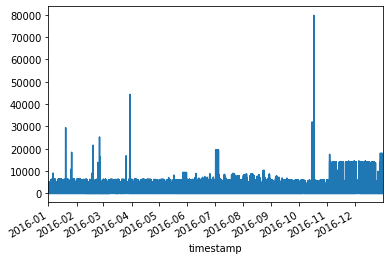

In [85]:
# simple plot  of meter readings over the whole year
train.loc[:, "meter_reading"].plot()

In [86]:
# summarizing electricity consumption over the whole year according to timestamp
summaryTimestampData = train.groupby([ "primary_use","timestamp"])["meter_reading"].agg("mean").reset_index()
summaryTimestampData.set_index(["primary_use"], inplace=True)
summaryTimestampData.set_index(["timestamp"], append=True, inplace=True)
summaryTimestampData

meter_reading
primary_use       timestamp                         
Education         2016-01-01 00:00:00     155.745087
                  2016-01-01 01:00:00     180.502006
                  2016-01-01 02:00:00     180.959793
                  2016-01-01 03:00:00     181.654707
                  2016-01-01 04:00:00     181.936468
...                                              ...
Warehouse/storage 2016-12-31 19:00:00      37.823667
                  2016-12-31 20:00:00      37.214750
                  2016-12-31 21:00:00      37.454500
                  2016-12-31 22:00:00      37.845917
                  2016-12-31 23:00:00      38.466167

[140544 rows x 1 columns]

Text(0, 0.5, 'mean meter reading')

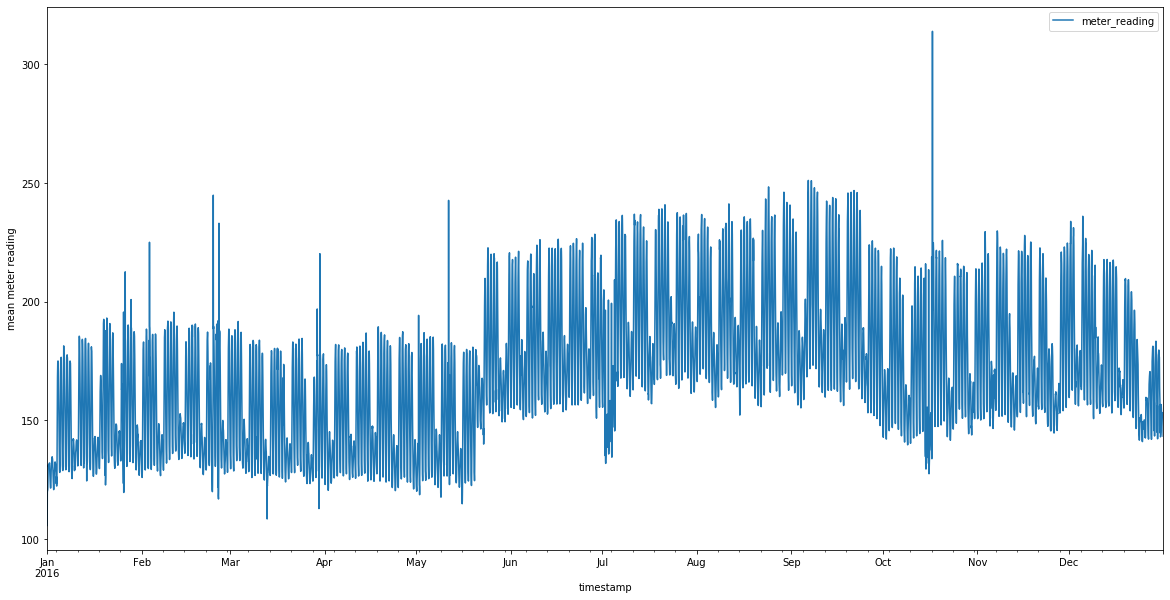

In [87]:
#plot the mean consumption of energy per month for the whole year to find patterns in data.
summaryTimestampOnly = train.groupby(["timestamp"]).agg("mean").reset_index()
summaryTimestampOnly.plot(x = "timestamp", y="meter_reading", figsize=(20,10))
plt.ylabel("mean meter reading")

### Generate the descriptive stats for each building

In [88]:
descriptiveStats = copy.deepcopy(train)
descriptiveStats.set_index(["building_id"], inplace=True)
descriptiveStats = descriptiveStats.groupby(descriptiveStats.index)["meter_reading"].agg(["min","max","mean","var"]).reset_index()
descriptiveStats.head(5)

building_id  min       max        mean            var
0            0  0.0   448.000  146.454978   14858.920316
1            1  0.0   255.000   74.865393    3814.963303
2            2  0.0    67.983   14.551385     258.045413
3            3  0.0   937.000  235.549966   42430.171429
4            4  0.0  3592.000  976.556746  607922.890332

In [89]:
#Adding a column for hour in the main dataframe to facilitate further analysis.
train["hour"] = train.index.hour
train.reset_index(inplace=True)
train.head(2)

timestamp  building_id  meter  meter_reading primary_use  hour
0 2016-01-01            0      0            0.0   Education     0
1 2016-01-01            1      0            0.0   Education     0

## Clustering over aggregate (mean) meter reading of each building for whole year for hour from 1 to 24

### Generate the pivot table using mean as the statistic

In [90]:
perHourElectricityConsumptionEachBuilding = train.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuilding.reset_index(inplace=True)
perHourElectricityConsumptionEachBuilding.head(5)

hour  building_id           0           1           2           3           4  \
0               0  146.731814  147.056316  147.326727  147.666140  147.088018   
1               1   74.311764   74.222252   73.795557   73.457637   73.752289   
2               2    7.909866    7.508163    7.319059    7.161287    7.562990   
3               3  226.090598  226.978330  227.878137  228.267901  228.887034   
4               4  939.801448  937.147732  934.602052  930.443253  930.812670   

hour           5           6           7           8  ...           14  \
0     146.992884  145.993318  148.096945  149.866737  ...   146.030618   
1      73.046615   72.224549   72.641547   73.271154  ...    76.454984   
2      10.379390   10.294349   11.020551   13.078301  ...    22.442803   
3     230.308093  231.220987  235.256678  247.010342  ...   240.660327   
4     935.789874  936.349617  941.304645  961.932433  ...  1034.626995   

hour           15           16           17          18          19  \
0      145.711705   145.713568   144.973208  146.140623  147.489625   
1       76.680267    76.612366    76.683993   76.953275   76.023033   
2       22.677781    22.008649    20.037058   17.865175   16.583607   
3      238.009302   230.922610   227.254320  228.883325  231.363251   
4     1031.346595  1023.746940  1001.146222  981.980350  983.184158   

hour          20          21          22          23  
0     146.483779  146.513631  147.162620  147.830235  
1      74.484870   73.510631   73.312941   73.875395  
2      14.758967   13.480005   10.763191    8.068755  
3     231.864396  236.639516  238.312370  231.446662  
4     969.433129  955.082541  949.193342  945.511803  

[5 rows x 25 columns]

### Generate the wcss vs cluster count and silhouette score vs cluster count plot

In [91]:
#setup for generating plot according to silhouette score for each number of clusters to extrcat the optimal number of clusters.
silhouette_scores = list()
inertia_list = list()
no_cluster = np.arange(2,30).astype(int) 

In [92]:
#scale the data for faster processing.
X = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())

In [93]:
#perform clustering with the required counts of clusters
for cluster in no_cluster:
    kmeans = KMeans(n_clusters=cluster, init="k-means++", n_init=10, n_jobs=-1,)
    c_f = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    inertia_list.append(kmeans.inertia_)

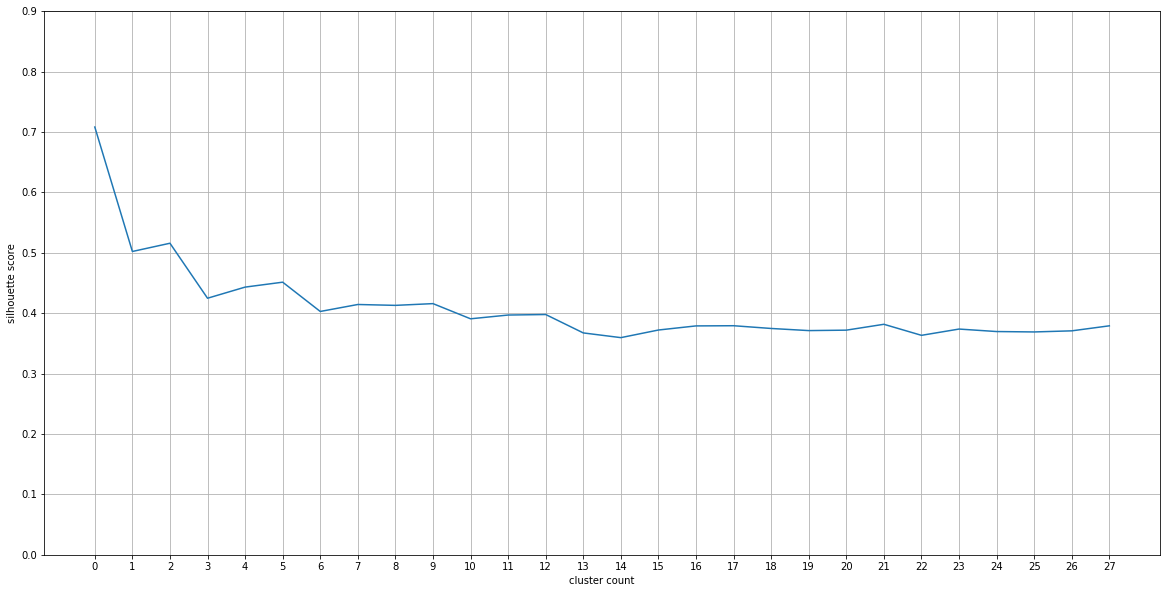

In [94]:
#plot the sihouette score vs cluster count graph.
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], silhouette_scores)
plt.xticks([i for i in range(0,28,1)])
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("cluster count")
plt.ylabel("silhouette score")
plt.grid()

### As silhouette score vs cluster count plot is not giving the desired result, we use elbow method to determine the best number of clusters

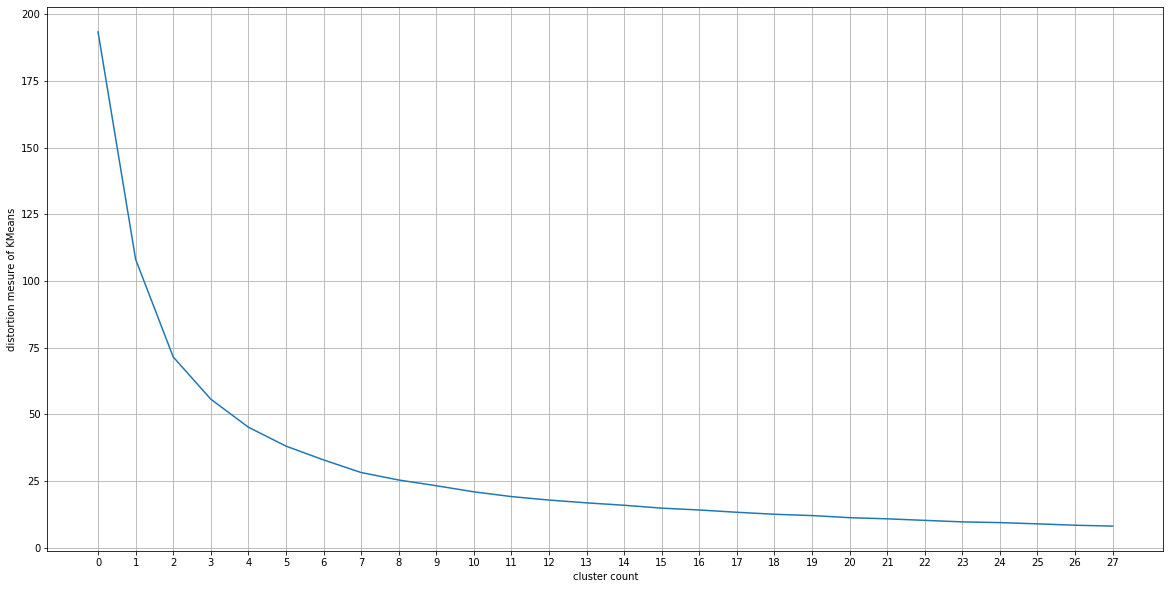

In [95]:
# plot the wcss vs cluster count graph
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], inertia_list)
plt.xticks([i for i in range(0,28,1)])
plt.xlabel("cluster count")
plt.ylabel("distortion mesure of KMeans")
plt.grid()

### check the output of internal validation measure for cluster count = 2

In [96]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index("building_id", inplace=True)
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.65555363 0.67207866 0.67781647 ... 0.67518127 0.64007389 0.67455563]
silhouette score on euclidean metric:  0.7119459018252732
calsinki-H score on euclidean metric:  739.1724238238038
davis-B score on euclidean metric:  0.7278955306221229


### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

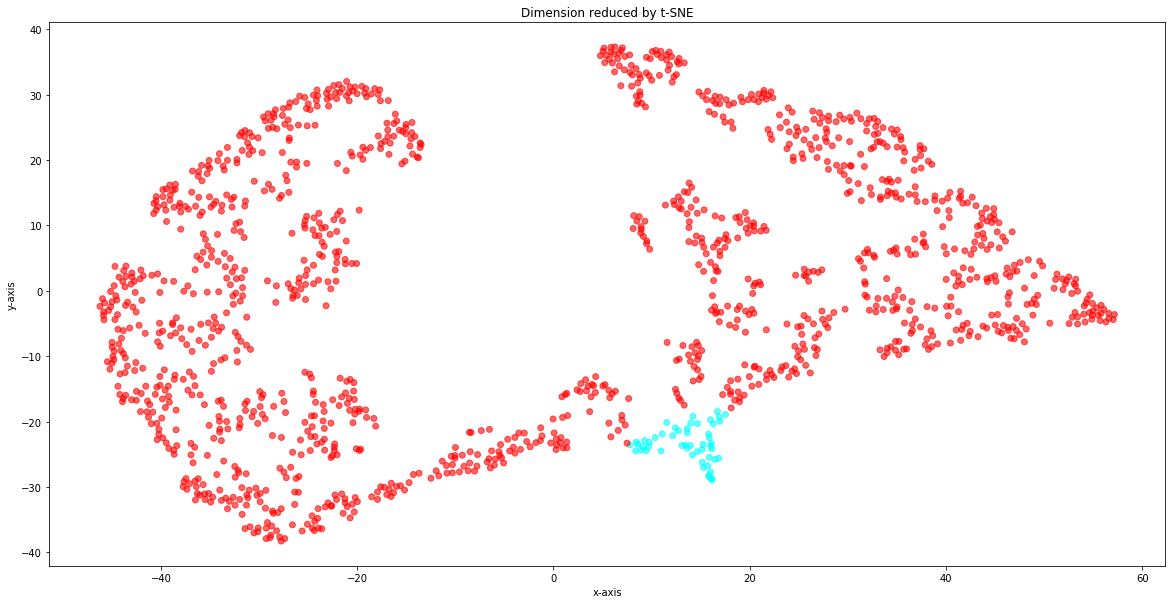

In [97]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

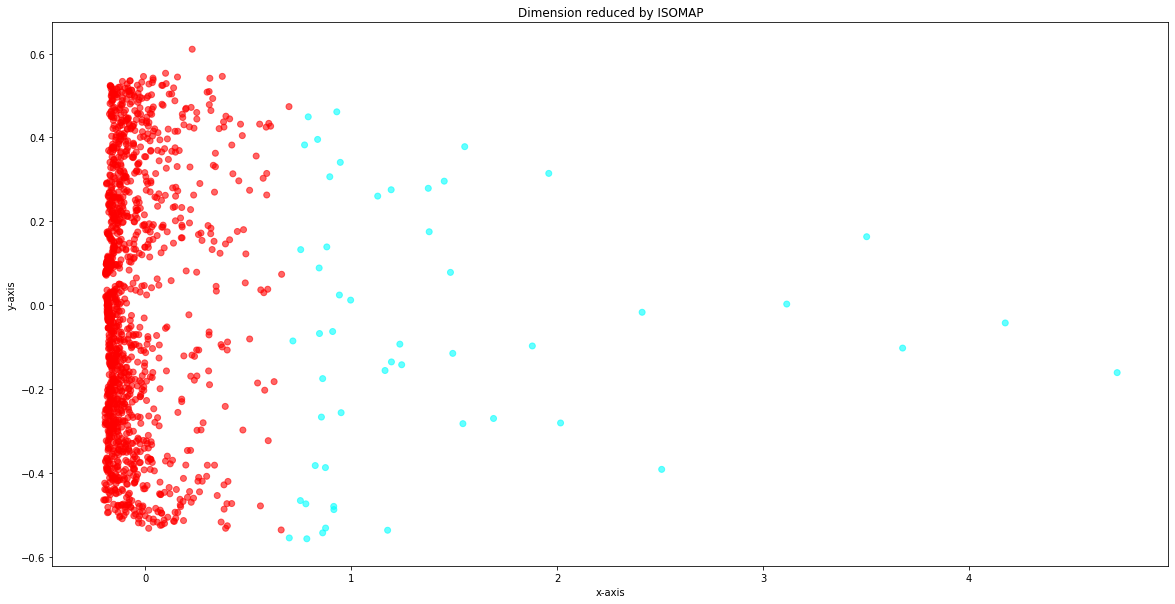

In [98]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

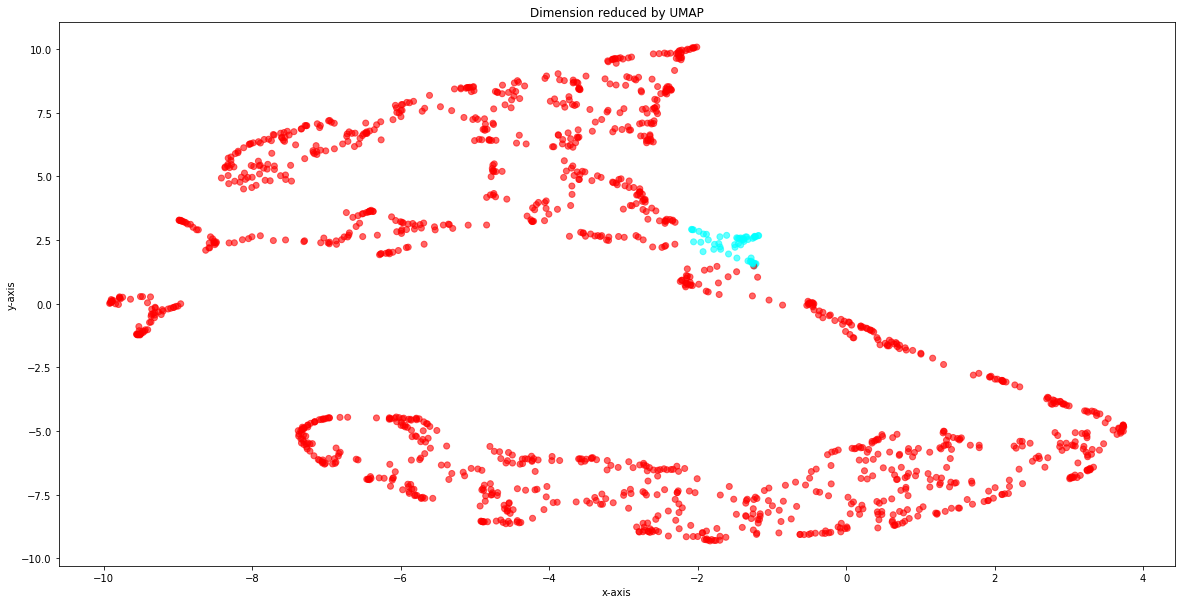

In [99]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

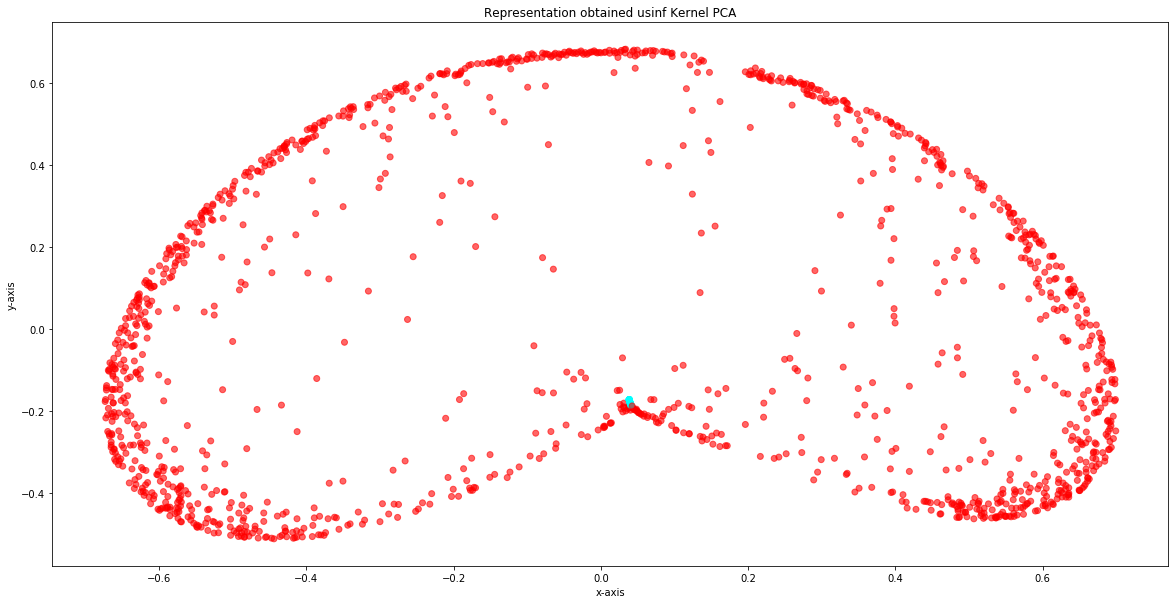

In [100]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="rbf", g=15,rzev=True, deg = 1)

### As we see isomap gives the best representation of 2D for our data. In the subsequent sections we still will plot the points obtained via all 3 dimensionality reduction techniques but ISOMAP will be our emphasis.

### check the output of internal validation measure for cluster count = 3

In [101]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.61167425 0.61843145 0.60478458 ... 0.59127806 0.60396502 0.5906737 ]
silhouette score on euclidean metric:  0.5021848787636697
calsinki-H score on euclidean metric:  1212.7376813215203
davis-B score on euclidean metric:  0.6996064899943542


### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

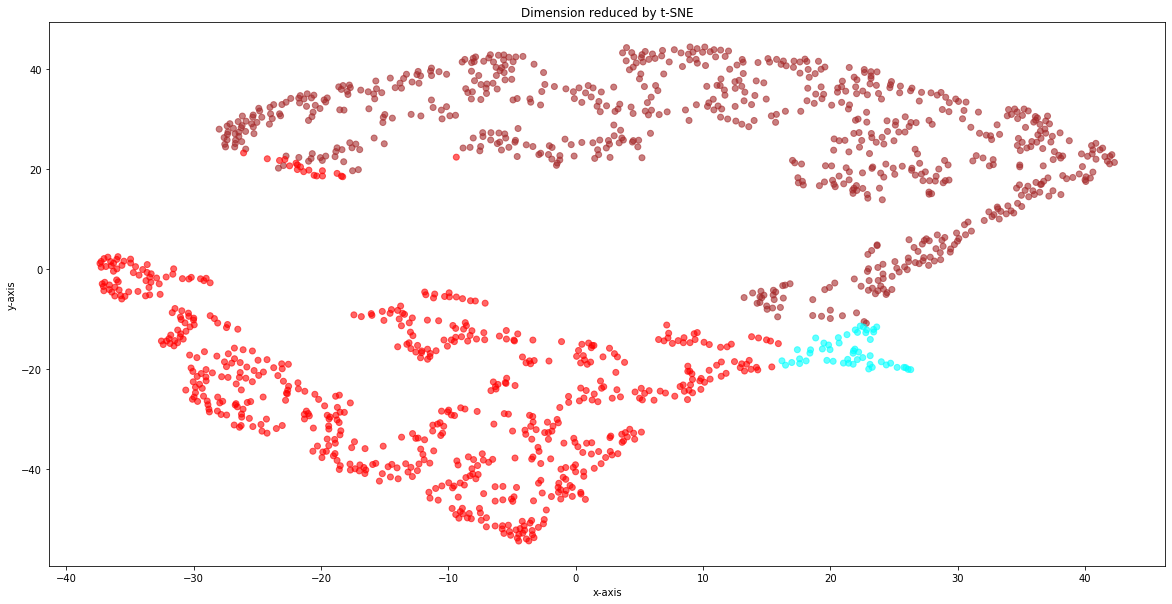

In [102]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

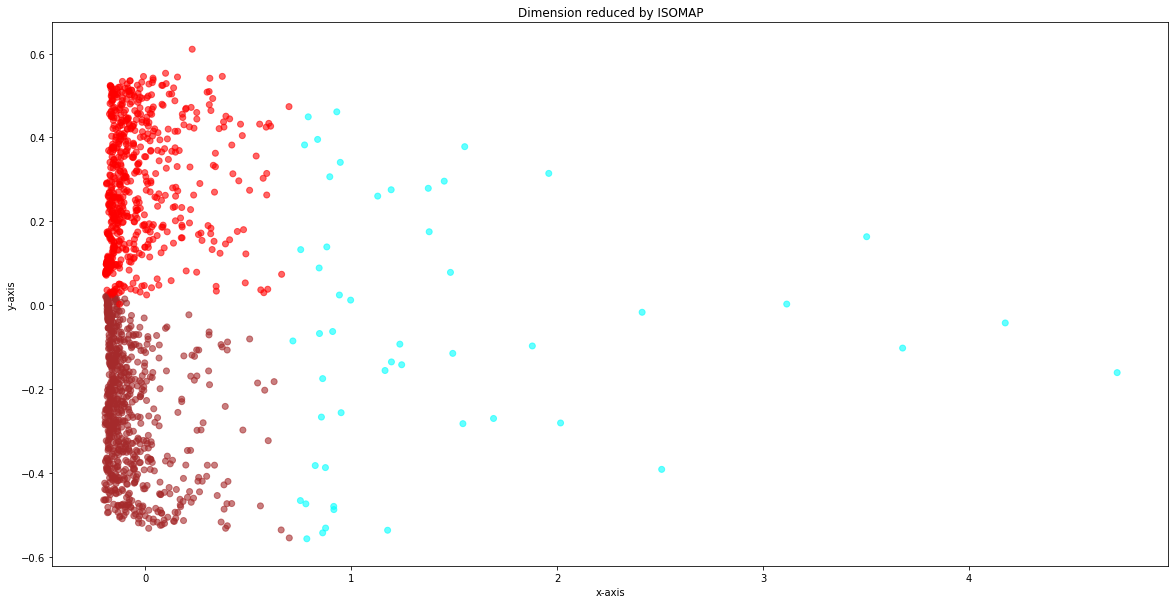

In [103]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

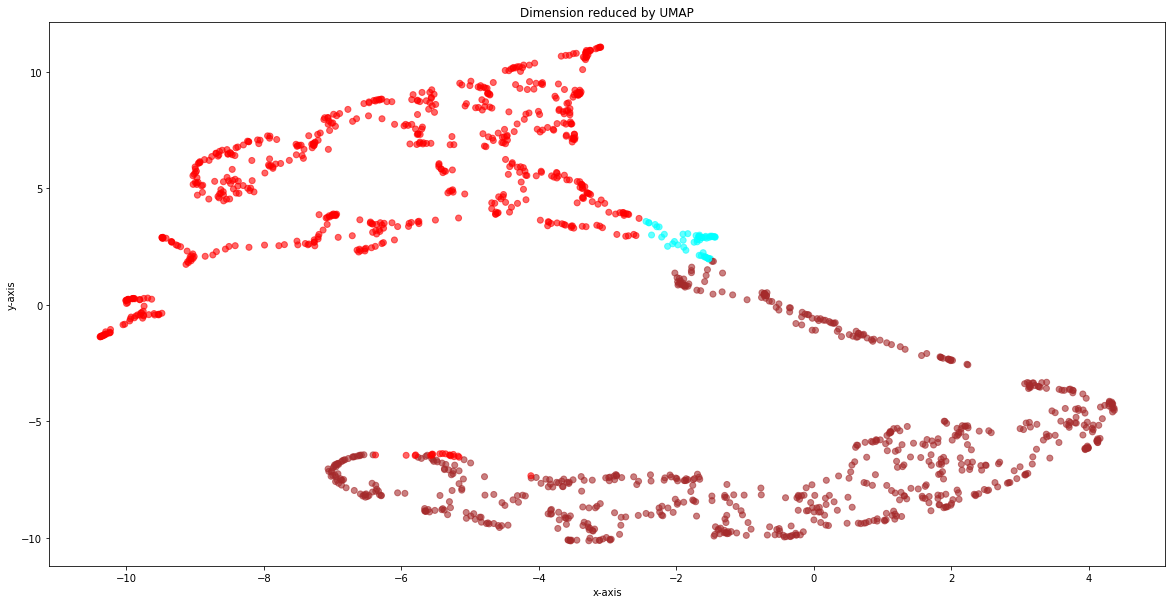

In [104]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

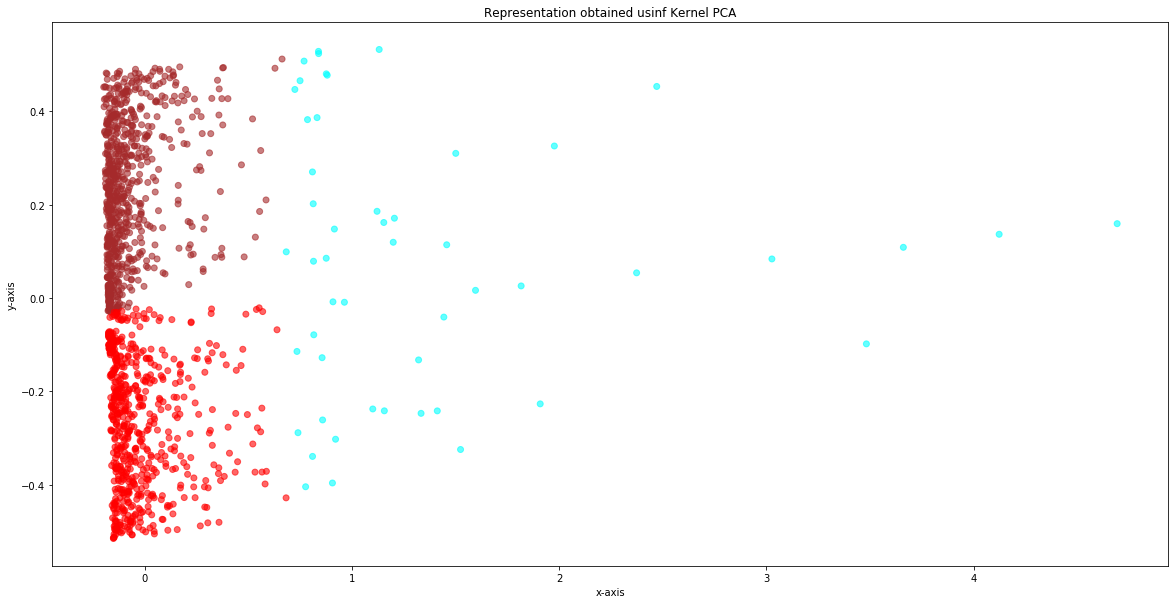

In [105]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="linear", g=30,rzev=True, deg = 1)

### check the output of internal validation measure for cluster count = 4

In [106]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=4)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.61598051 0.62324232 0.60953678 ... 0.60640773 0.6131152  0.60574799]
silhouette score on euclidean metric:  0.5158280888178522
calsinki-H score on euclidean metric:  1460.2662274547997
davis-B score on euclidean metric:  0.622681911358519


### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

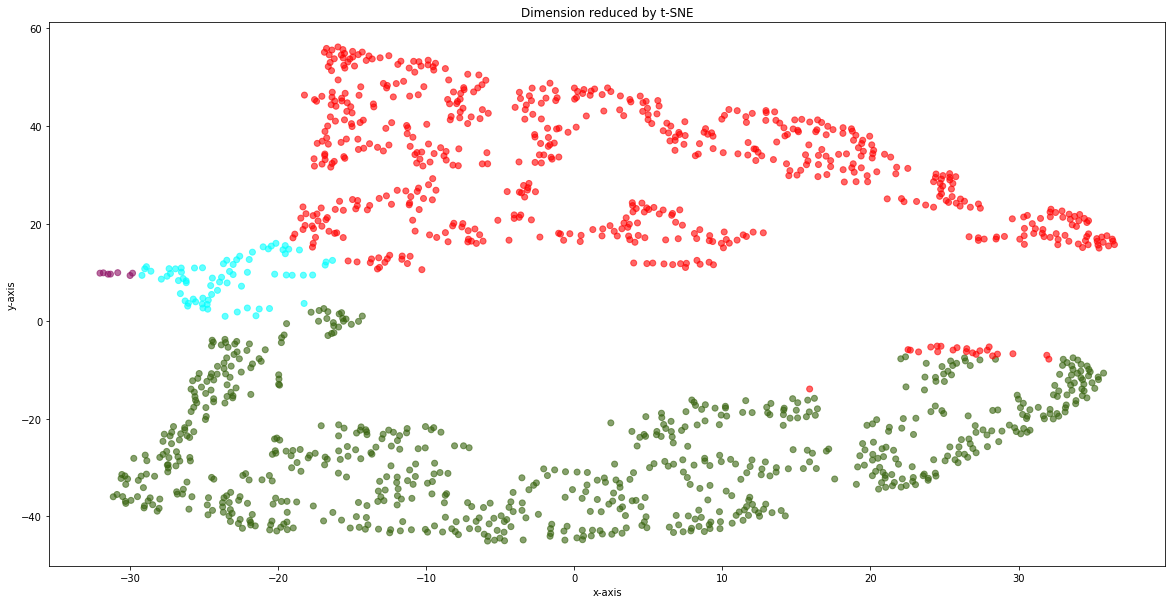

In [107]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

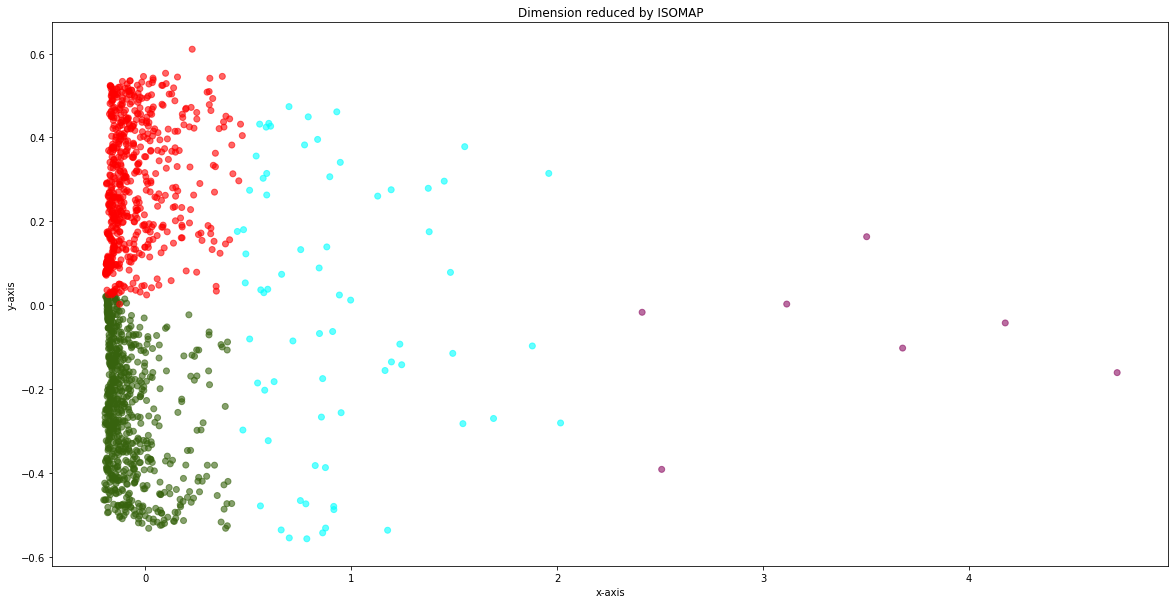

In [108]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

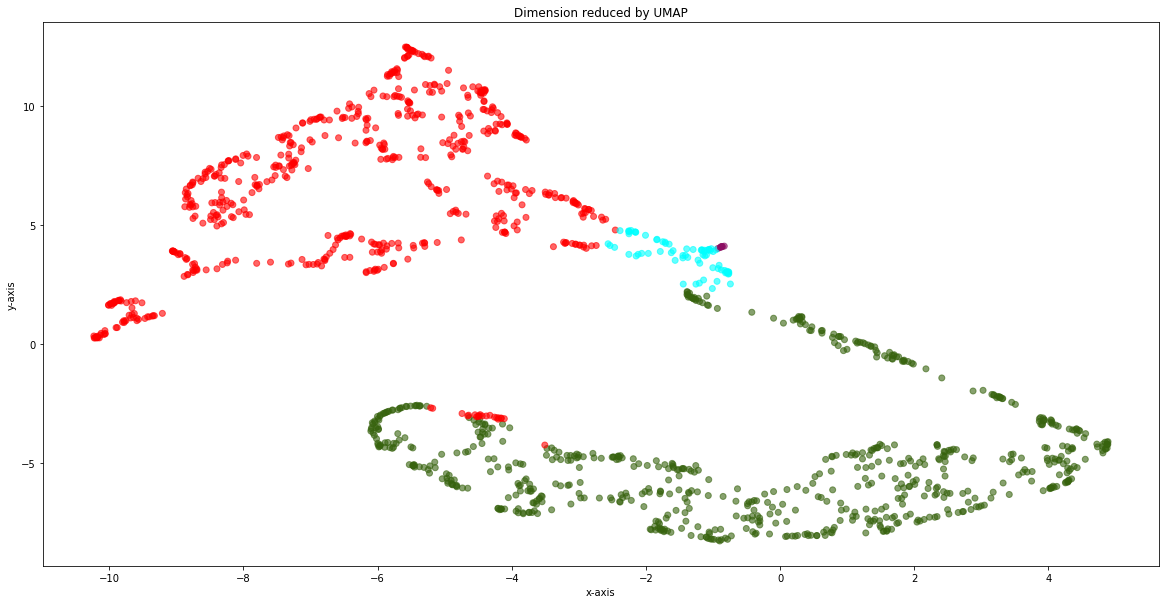

In [109]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

### We see that even increasing the cluster count does not improve the internal validation score of our clusters. Hence, we shall be dividing the data into quarters and experimenting with the same technique once again. 

### Some other observations

### Associate each building with its primary use

In [110]:
#map corresponding building to its primary use
temp = train.drop_duplicates(["building_id","primary_use"])
temp = temp[["building_id", "primary_use"]]
temp.set_index("building_id")
temp.sort_values(by="building_id", inplace=True) 

### Get a count of total number of each category in primary use

In [111]:
#make a copy oforiginalpivot_table
temp2 = copy.deepcopy(perHourElectricityConsumptionEachBuilding)
perHourElectricityConsumptionEachBuilding.reset_index(level = ["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding = pd.merge(perHourElectricityConsumptionEachBuilding,temp, left_on="building_id", right_on="building_id", how="left")
perHourElectricityConsumptionEachBuilding.set_index(["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding.groupby([perHourElectricityConsumptionEachBuilding.index.get_level_values("cluster"),"primary_use"])["primary_use"].agg("count")
perHourElectricityConsumptionEachBuilding

0           1           2           3  \
building_id cluster                                                   
0           1        146.731814  147.056316  147.326727  147.666140   
1           1         74.311764   74.222252   73.795557   73.457637   
2           1          7.909866    7.508163    7.319059    7.161287   
3           1        226.090598  226.978330  227.878137  228.267901   
4           3        939.801448  937.147732  934.602052  930.443253   
...                         ...         ...         ...         ...   
1444        0          8.246222    8.218162    8.119071    8.085337   
1445        0          3.979582    3.955342    3.955609    3.972837   
1446        0          3.428125    0.438141    0.114503    0.065304   
1447        0        193.410096  189.166426  184.345353  180.363061   
1448        0          2.820257    2.794453    2.839711    2.769936   

                              4           5           6           7  \
building_id cluster                                                   
0           1        147.088018  146.992884  145.993318  148.096945   
1           1         73.752289   73.046615   72.224549   72.641547   
2           1          7.562990   10.379390   10.294349   11.020551   
3           1        228.887034  230.308093  231.220987  235.256678   
4           3        930.812670  935.789874  936.349617  941.304645   
...                         ...         ...         ...         ...   
1444        0          8.124519    7.990385    7.295726    6.918515   
1445        0          3.974439    4.001763    4.018629    5.356371   
1446        0          0.010737    0.604327    3.995820    5.904582   
1447        0        178.524519  176.569926  171.782958  173.622508   
1448        0          2.836736    3.703162    4.024382    3.908710   

                              8           9  ...           15           16  \
building_id cluster                          ...                             
0           1        149.866737  144.788548  ...   145.711705   145.713568   
1           1         73.271154   74.161099  ...    76.680267    76.612366   
2           1         13.078301   16.351234  ...    22.677781    22.008649   
3           1        247.010342  252.037224  ...   238.009302   230.922610   
4           3        961.932433  996.927675  ...  1031.346595  1023.746940   
...                         ...         ...  ...          ...          ...   
1444        0          6.064148    5.887942  ...     5.812704     6.482016   
1445        0          4.826420    4.701340  ...     5.165936     5.245565   
1446        0          7.045900    7.763049  ...     4.804946     4.320418   
1447        0        180.348743  180.068865  ...   184.328065   186.543650   
1448        0          3.823710    3.807823  ...     3.664833     3.502823   

                              17          18          19          20  \
building_id cluster                                                    
0           1         144.973208  146.140623  147.489625  146.483779   
1           1          76.683993   76.953275   76.023033   74.484870   
2           1          20.037058   17.865175   16.583607   14.758967   
3           1         227.254320  228.883325  231.363251  231.864396   
4           3        1001.146222  981.980350  983.184158  969.433129   
...                          ...         ...         ...         ...   
1444        0           8.016694    8.429502    8.525968    9.028226   
1445        0           5.409462    5.310308    5.228457    5.156958   
1446        0           3.894051    3.616559    2.414871    0.427814   
1447        0         191.997373  194.324920  197.075884  204.870096   
1448        0           3.617204    3.384435    2.912581    2.927177   

                             21          22          23  \
building_id cluster                                       
0           1        146.513631  147.162620  147.830235   
1           1         73.510631   73.312941   73.8753

### assign a numeric value to each categpry in primary use for further use in later sections

In [112]:
perHourElectricityConsumptionEachBuilding["code"] = perHourElectricityConsumptionEachBuilding["primary_use"].astype("category").cat.codes
perHourElectricityConsumptionEachBuilding

0           1           2           3  \
building_id cluster                                                   
0           1        146.731814  147.056316  147.326727  147.666140   
1           1         74.311764   74.222252   73.795557   73.457637   
2           1          7.909866    7.508163    7.319059    7.161287   
3           1        226.090598  226.978330  227.878137  228.267901   
4           3        939.801448  937.147732  934.602052  930.443253   
...                         ...         ...         ...         ...   
1444        0          8.246222    8.218162    8.119071    8.085337   
1445        0          3.979582    3.955342    3.955609    3.972837   
1446        0          3.428125    0.438141    0.114503    0.065304   
1447        0        193.410096  189.166426  184.345353  180.363061   
1448        0          2.820257    2.794453    2.839711    2.769936   

                              4           5           6           7  \
building_id cluster                                                   
0           1        147.088018  146.992884  145.993318  148.096945   
1           1         73.752289   73.046615   72.224549   72.641547   
2           1          7.562990   10.379390   10.294349   11.020551   
3           1        228.887034  230.308093  231.220987  235.256678   
4           3        930.812670  935.789874  936.349617  941.304645   
...                         ...         ...         ...         ...   
1444        0          8.124519    7.990385    7.295726    6.918515   
1445        0          3.974439    4.001763    4.018629    5.356371   
1446        0          0.010737    0.604327    3.995820    5.904582   
1447        0        178.524519  176.569926  171.782958  173.622508   
1448        0          2.836736    3.703162    4.024382    3.908710   

                              8           9  ...           16           17  \
building_id cluster                          ...                             
0           1        149.866737  144.788548  ...   145.713568   144.973208   
1           1         73.271154   74.161099  ...    76.612366    76.683993   
2           1         13.078301   16.351234  ...    22.008649    20.037058   
3           1        247.010342  252.037224  ...   230.922610   227.254320   
4           3        961.932433  996.927675  ...  1023.746940  1001.146222   
...                         ...         ...  ...          ...          ...   
1444        0          6.064148    5.887942  ...     6.482016     8.016694   
1445        0          4.826420    4.701340  ...     5.245565     5.409462   
1446        0          7.045900    7.763049  ...     4.320418     3.894051   
1447        0        180.348743  180.068865  ...   186.543650   191.997373   
1448        0          3.823710    3.807823  ...     3.502823     3.617204   

                             18          19          20          21  \
building_id cluster                                                   
0           1        146.140623  147.489625  146.483779  146.513631   
1           1         76.953275   76.023033   74.484870   73.510631   
2           1         17.865175   16.583607   14.758967   13.480005   
3           1        228.883325  231.363251  231.864396  236.639516   
4           3        981.980350  983.184158  969.433129  955.082541   
...                         ...         ...         ...         ...   
1444        0          8.429502    8.525968    9.028226    9.809628   
1445        0          5.310308    5.228457    5.156958    5.222403   
1446        0          3.616559    2.414871    0.427814    0.092605   
1447        0        194.324920  197.075884  204.870096  211.548065   
1448        0          3.384435    2.912581    2.927177    2.930806   

                             22          23                    primary_use  \
building_id cluster                                                          
0           1        147.162620  147.830235                      Education   
1        

# Divide data into quarters and perform the above experiment.

#### Experiment over quarter 1

In [113]:
quarter1 = copy.deepcopy(train)
quarter1["quarter"] = quarter1["timestamp"].dt.quarter
quarter1 = quarter1[quarter1["quarter"]==1]
quarter1["meter_reading"].fillna(0, inplace=True)

In [114]:
perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
#perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
perHourElectricityConsumptionEachBuildingQ1.head(5)

hour               0         1         2         3         4         5   \
building_id                                                               
0            0.000000  0.000000  0.000000  0.000000  0.000000  0.412536   
1            0.135012  0.744066  0.270024  0.927081  0.768067  0.804071   
2            0.000000  0.018001  0.000000  0.000000  0.000000  0.000000   
3            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4            0.000000  0.907580  0.840074  0.997588  0.900079  0.802570   

hour               6         7         8         9   ...       14        15  \
building_id                                          ...                      
0            0.000000  0.000000  0.480043  0.000000  ...  0.00000  0.000000   
1            0.192016  0.627055  0.129011  1.188105  ...  0.69606  0.255022   
2            0.000000  0.000000  0.000000  0.013501  ...  0.00000  0.000000   
3            0.000000  0.000000  0.000000  0.000000  ...  0.00000  0.000000   
4            0.000000  0.000000  0.937582  1.725153  ...  0.00000  2.970260   

hour               16        17        18        19        20        21  \
building_id                                                               
0            0.000000  0.577551  0.000000  0.000000  0.000000  0.000000   
1            0.255022  0.474042  1.317115  0.708063  0.513046  1.200107   
2            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4            1.230110  0.900079  1.020090  0.855076  0.952584  0.000000   

hour               22       23  
building_id                     
0            0.000000  0.00000  
1            0.759067  1.46413  
2            0.000000  0.00000  
3            0.000000  0.00000  
4            1.005089  0.00000  

[5 rows x 24 columns]

In [115]:
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
XQ1

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.72443111e-05, 1.50051478e-04, 5.45043659e-05, ...,
        2.41389109e-04, 1.52766255e-04, 2.95405686e-04],
       [0.00000000e+00, 3.63017760e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.45882413e-04, 7.96104690e-05, 7.35813474e-05, ...,
        8.38082183e-06, 0.00000000e+00, 6.62881912e-04],
       [3.73213645e-02, 3.64698020e-02, 3.59211933e-02, ...,
        4.00883443e-02, 3.94359739e-02, 3.79828638e-02],
       [5.91179124e-04, 5.65715041e-04, 5.81374792e-04, ...,
        6.29040542e-04, 5.90426854e-04, 5.83936676e-04]])

In [116]:
silhouette_scores_q1 = list()
inertia = list()
no_cluster = np.arange(2,28).astype("int")
for cluster in no_cluster:
    kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
    c_f = kmeansQ1.fit_predict(XQ1)
    silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
    inertia.append(kmeansQ1.inertia_)
    

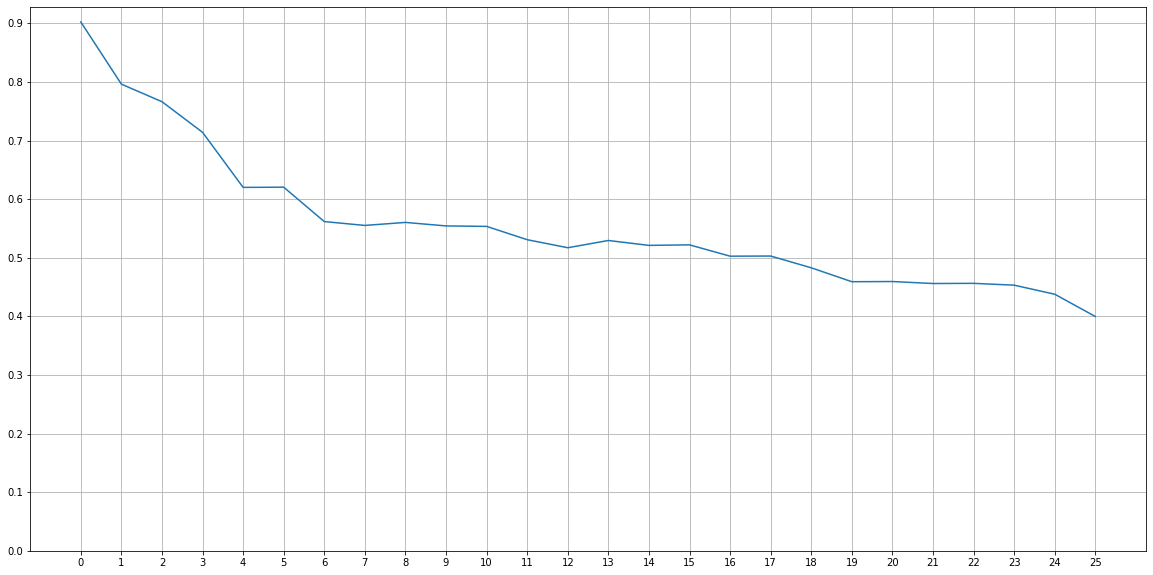

In [117]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
plt.xticks([i for i in range(0,26,1)])
plt.yticks(np.arange(0,1,0.1))
plt.grid()

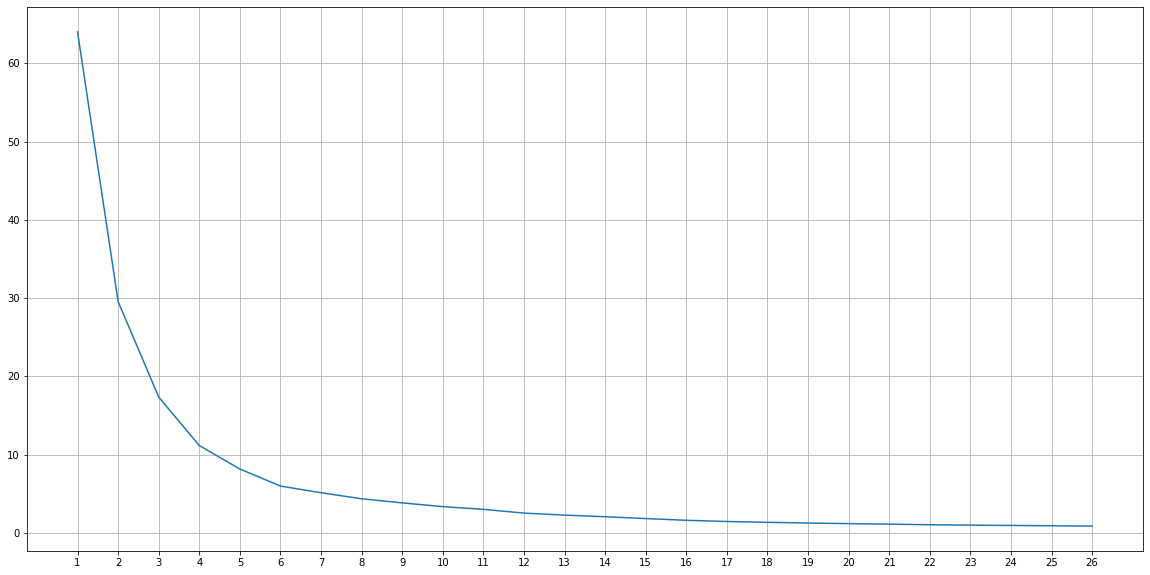

In [118]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1,27,1)], inertia)
plt.xticks([i for i in range(1,27,1)])
plt.grid()

#### Clustering with euclidean distance

In [119]:
kmeans = KMeans(n_clusters=3)
cluster_found_q1 = kmeans.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

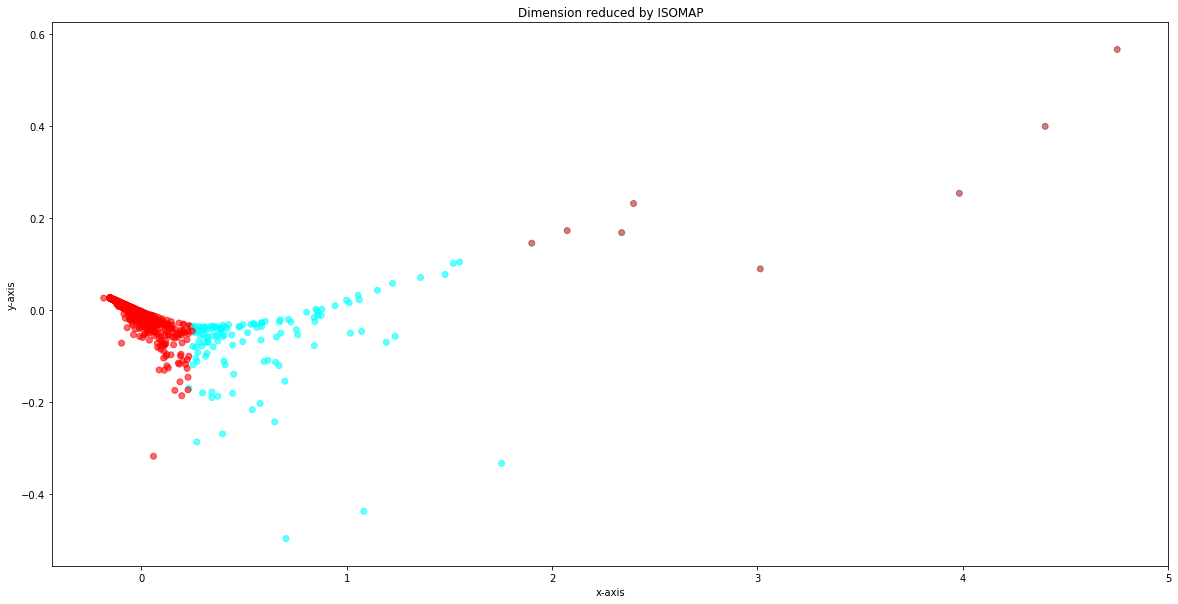

In [120]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10)

#### Clustering with DTW distance

In [121]:
perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

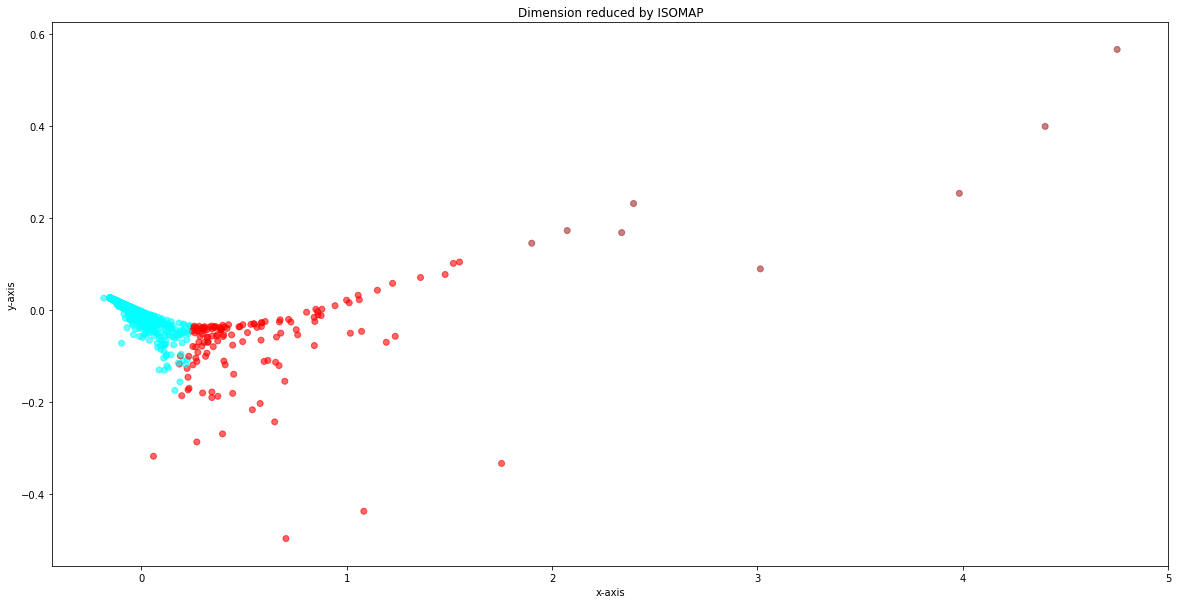

In [122]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10)

In [123]:
# printing the score of internal validation measures
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))

silhouette score on euclidean metric:  0.796180615029793
silhouette score on dtw metric:  0.7914814676686843
calsinki-H score on euclidean metric:  2593.5246018334324
calsinki-H score on dtw metric:  2568.0645499716998
davis-B score on euclidean metric:  0.5274683701096538
davis-B score on dtw metric:  0.5353731460608793


## Perform Kmeans on quarter 2 with distances: euclidean, DTW

Internal Validation scores for quarter 2
silhouette score on euclidean metric:  0.7990337143334691
silhouette score on dtw metric:  0.8136899879160124
calsinki-H score on euclidean metric:  2744.3125876577046
calsinki-H score on dtw metric:  2585.208474928259
davis-B score on euclidean metric:  0.49897876863803275
davis-B score on dtw metric:  0.46311930102108706


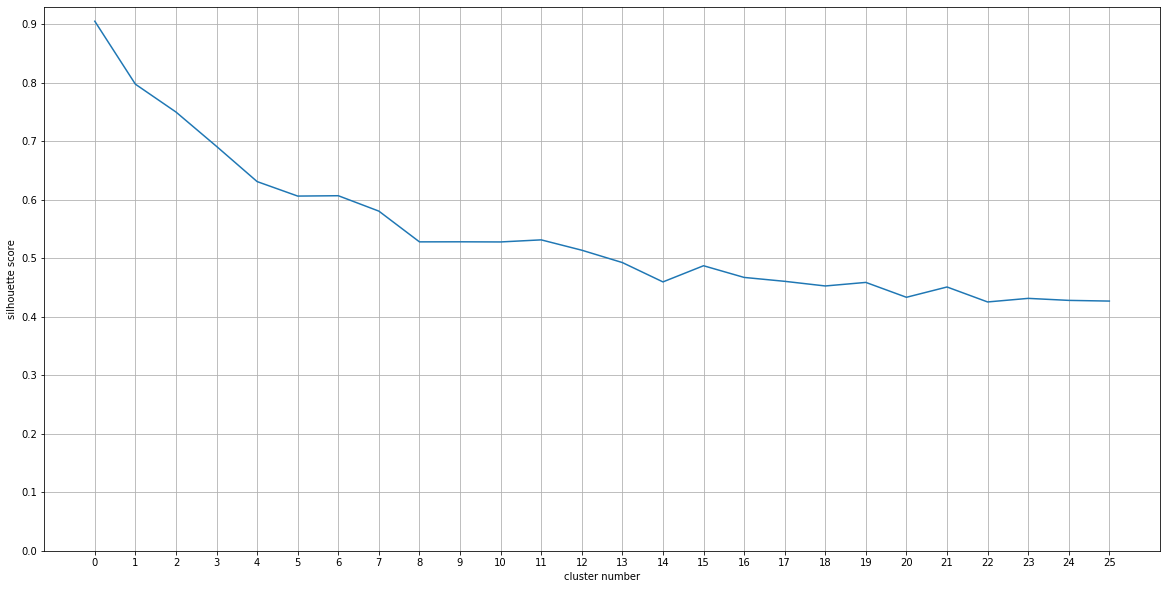

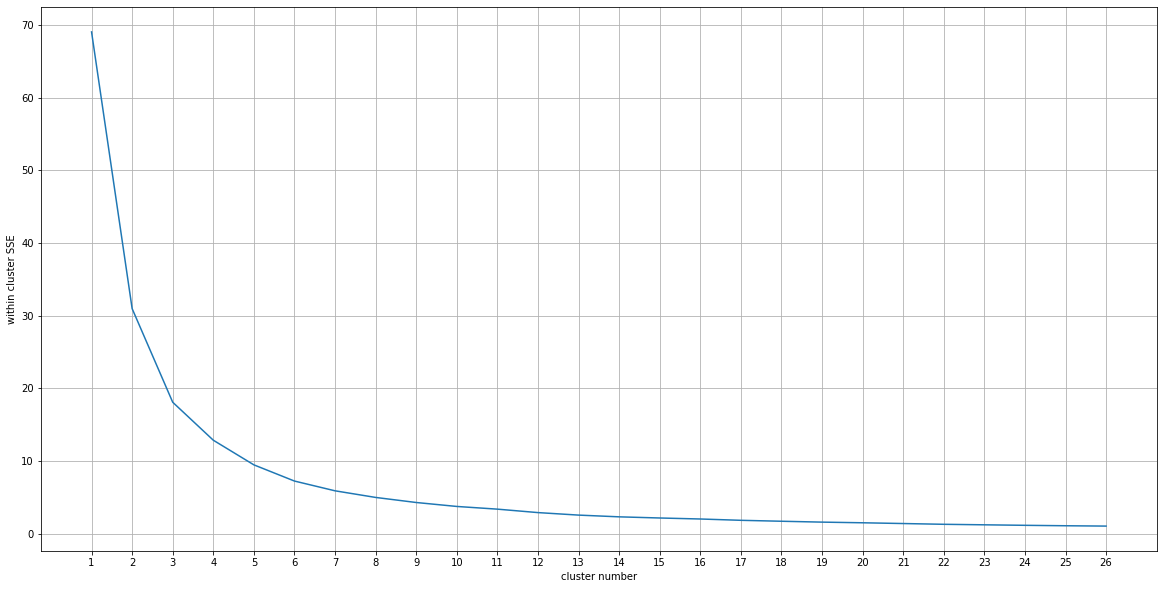

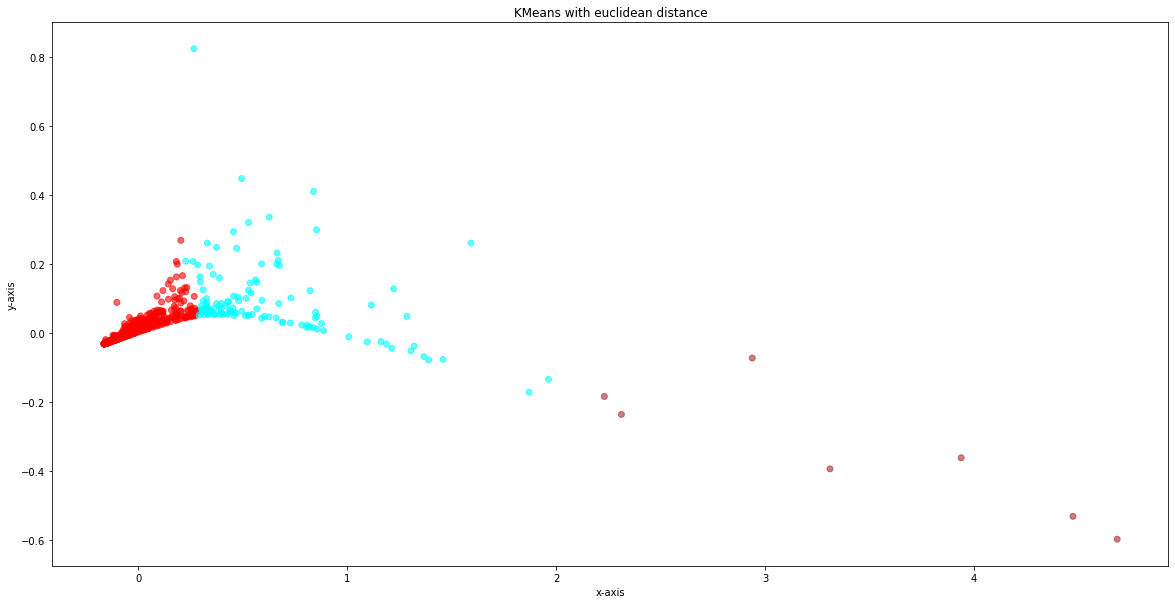

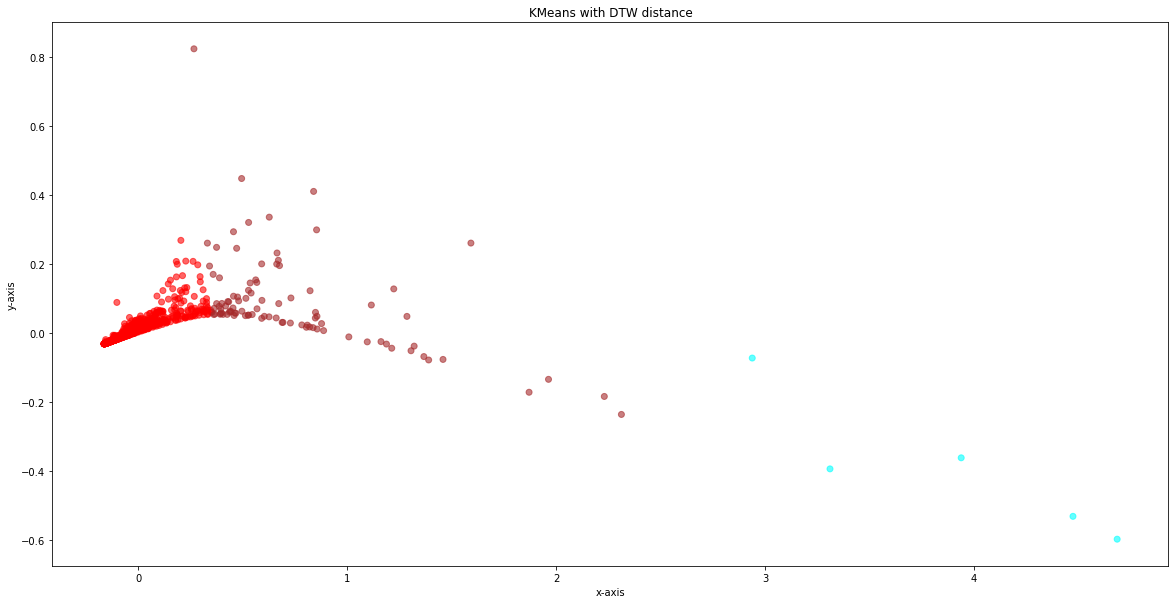

In [124]:
perform_clustering_quarter_wise(2, train)

## Perform Kmeans on quarter 3 with distances: euclidean, DTW

Internal Validation scores for quarter 3
silhouette score on euclidean metric:  0.816025803081068
silhouette score on dtw metric:  0.8085373861070171
calsinki-H score on euclidean metric:  2542.8187786594904
calsinki-H score on dtw metric:  2536.164787179578
davis-B score on euclidean metric:  0.48547751111140425
davis-B score on dtw metric:  0.4960525182456809


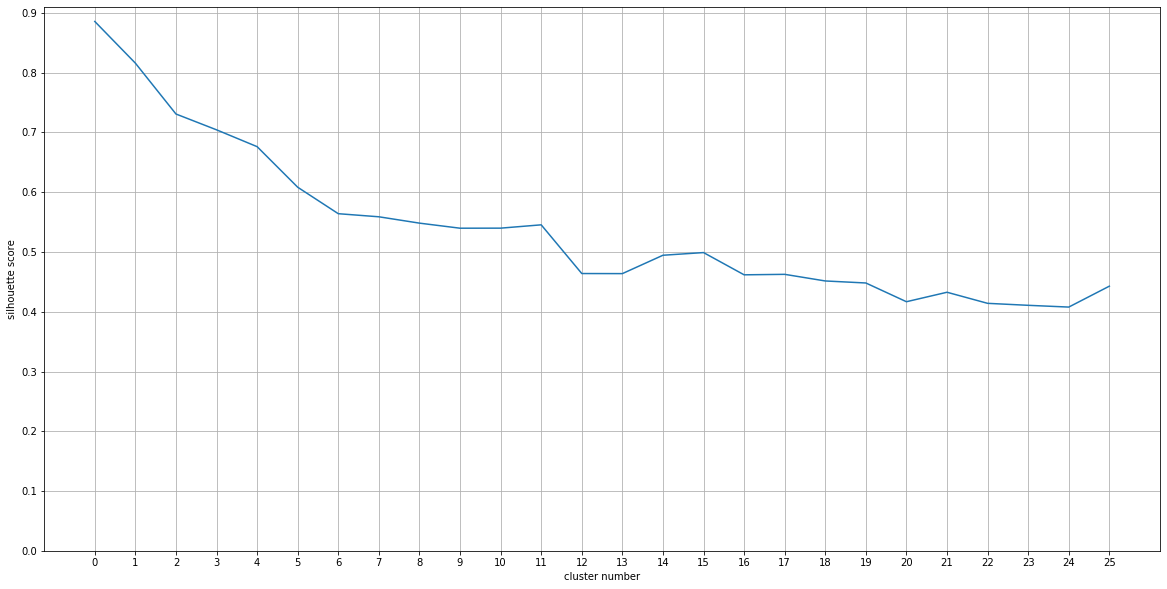

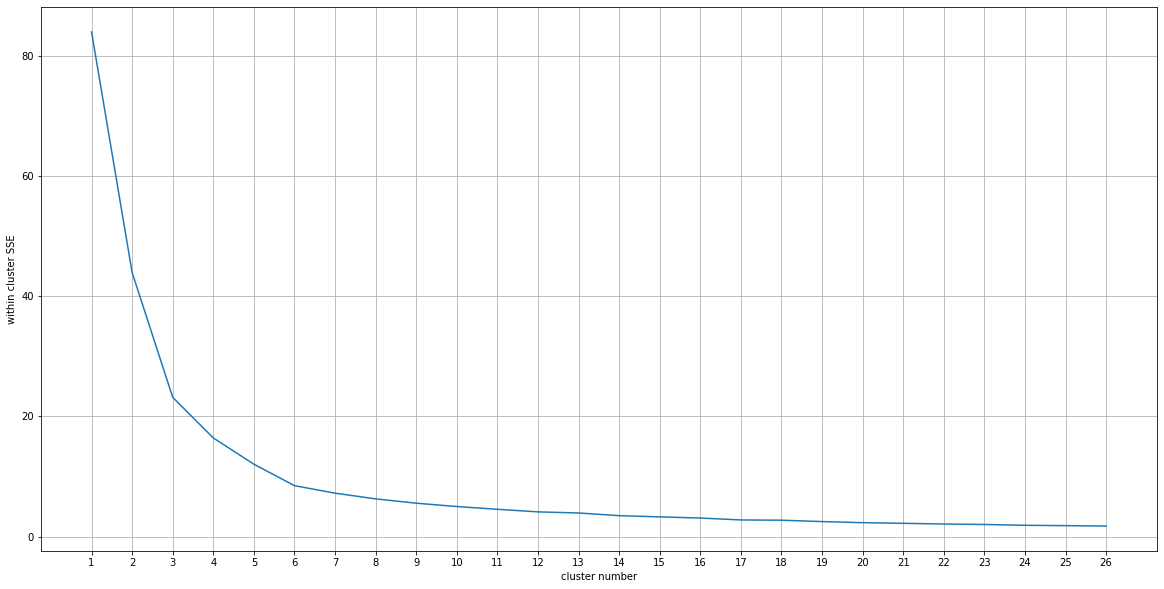

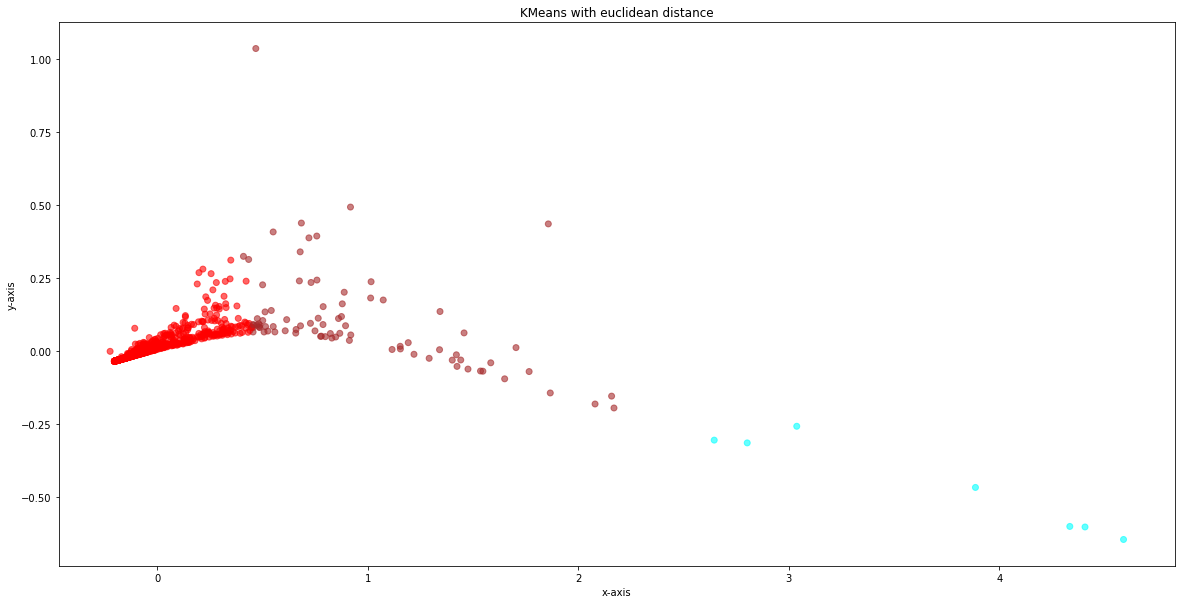

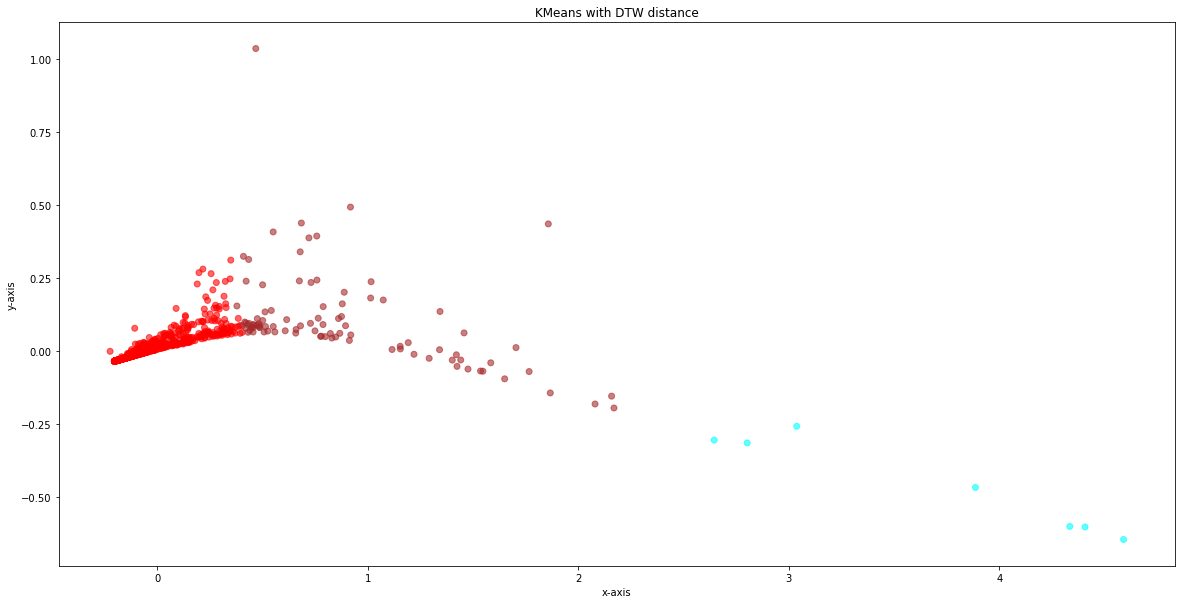

In [125]:
perform_clustering_quarter_wise(3, train)

## Perform Kmeans on quarter 4 with distances: euclidean, DTW

Internal Validation scores for quarter 4
silhouette score on euclidean metric:  0.796594122585544
silhouette score on dtw metric:  0.7886395173310671
calsinki-H score on euclidean metric:  2255.03392704363
calsinki-H score on dtw metric:  2237.5362962530235
davis-B score on euclidean metric:  0.5301922499277355
davis-B score on dtw metric:  0.5470545151214874


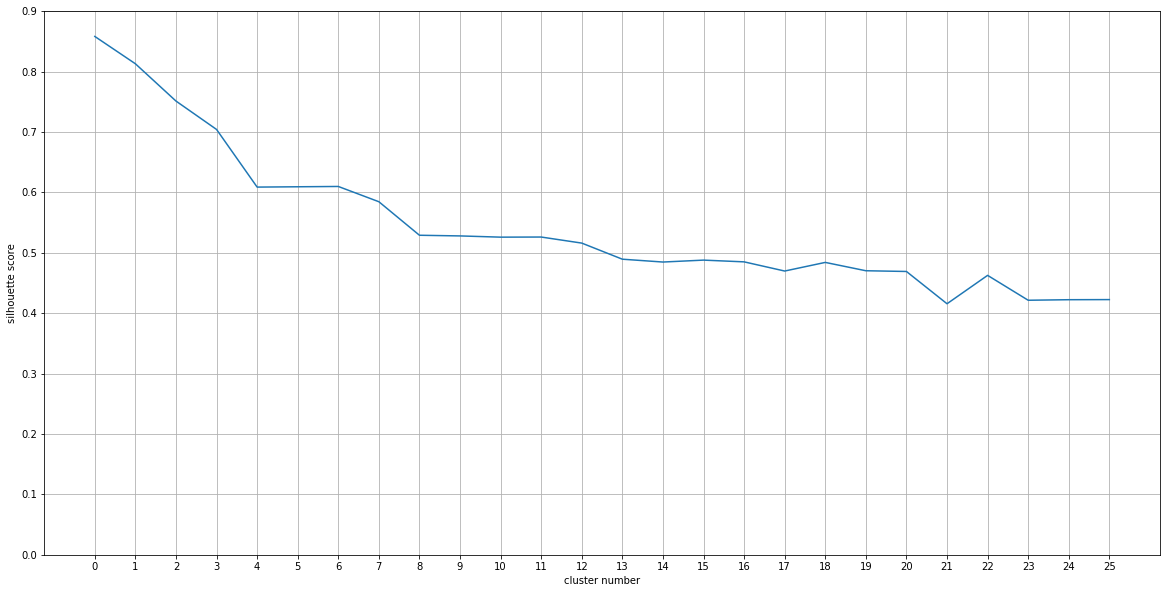

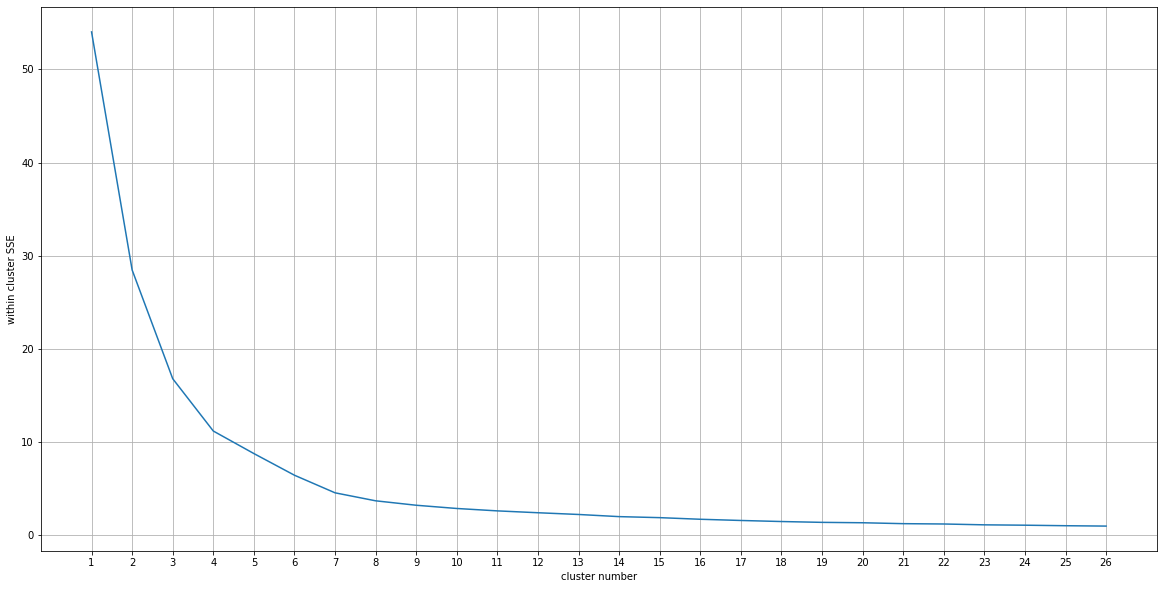

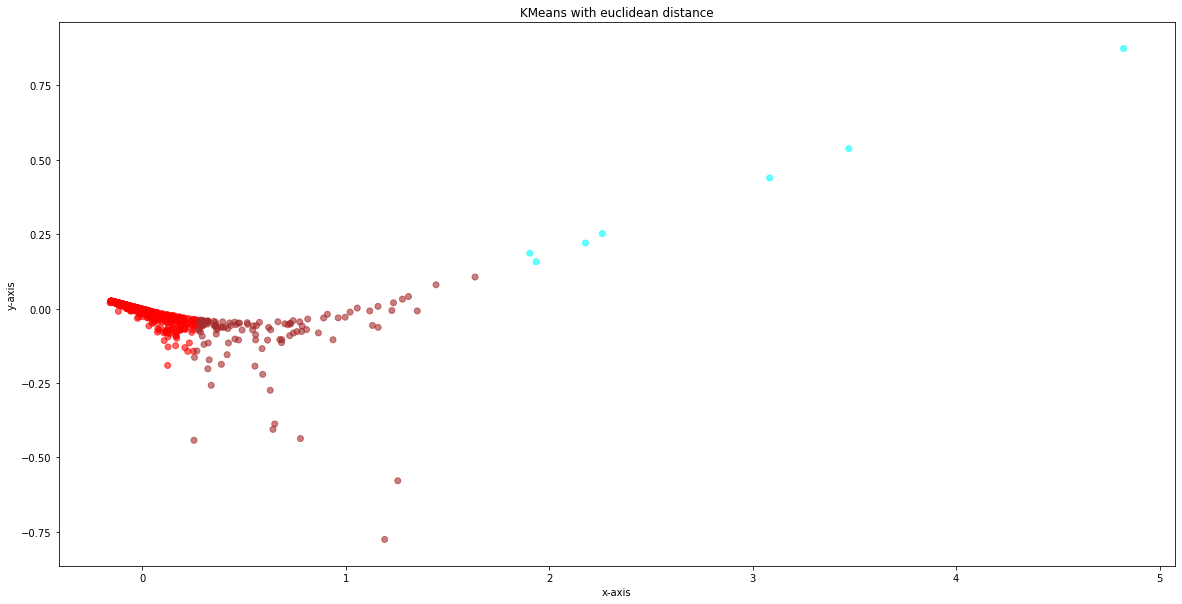

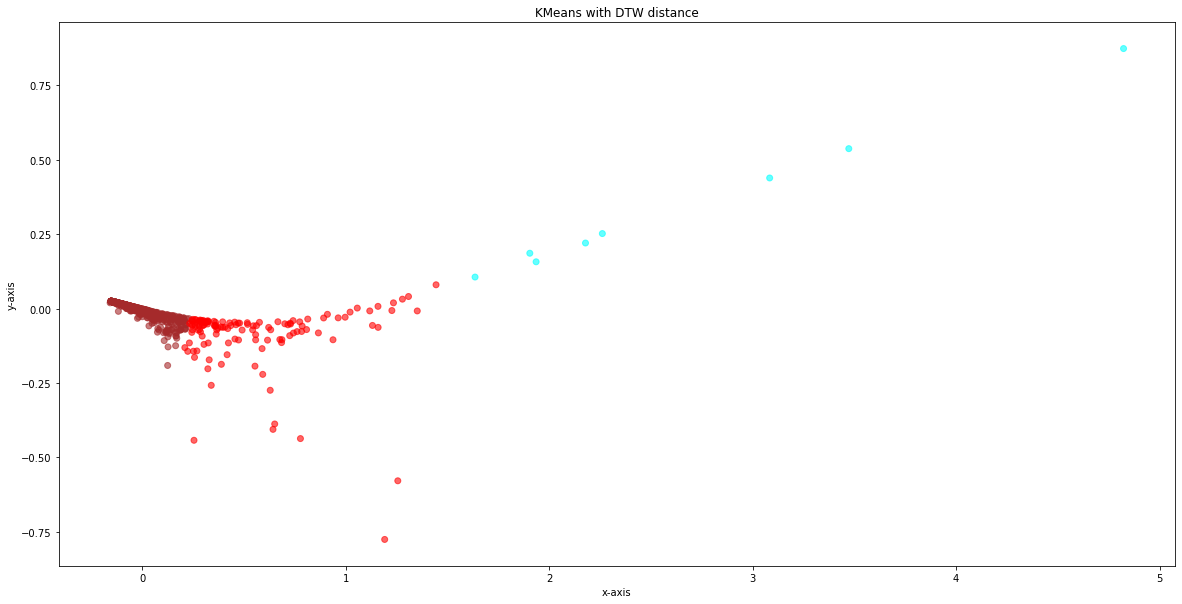

In [126]:
perform_clustering_quarter_wise(4, train)

## Outcome: KMeans with DTW distance does perform better than euclidean distance i.e. Measures based on editing of the time series performed better than shape based distance in the above case. 

# Experiment with spectral clustering..
### 1. First with whole year aggregate data
### 2. Then with quarterly data if the score is not according to the requirement.

In [127]:
wholeYear = copy.deepcopy(train)
perHourElectricityConsumptionEachBuildingWholeYear = wholeYear.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingWholeYear.values.copy())

spectralCluster = SpectralClustering(n_clusters=2, n_init=10, assign_labels="discretize", n_jobs=-1, random_state=0, degree=3, affinity="nearest_neighbors")
cluster_found_q1 = spectralCluster.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingWholeYear.set_index(cluster_found_sr_q1, append=True, inplace=True)

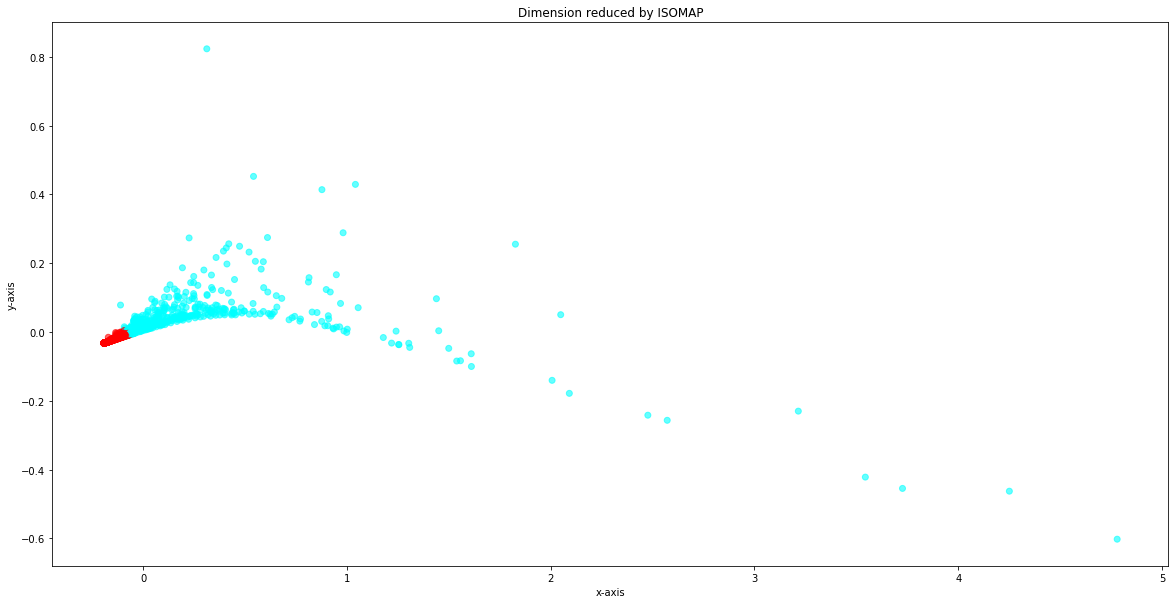

In [128]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingWholeYear, neighbor=10, dimension=2)

In [129]:
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))

silhouette score on euclidean metric:  0.4657260028207865
calsinki-H score on euclidean metric:  429.90564891651775
davis-B score on euclidean metric:  0.8797308640435977


In [130]:
def perform_spectral_cluster_quarter_wise(quarter_no=1, ncl  = 8,train=None):
    wholeYear = copy.deepcopy(train)
    if quarter_no>0:
        wholeYear["quarter"] = wholeYear["timestamp"].dt.quarter
        wholeYear = wholeYear[wholeYear["quarter"]==quarter_no]
    wholeYear.fillna(0, inplace=True)
    
    perHourElectricityConsumptionEachBuilding = wholeYear.pivot(values="meter_reading", index="building_id", columns="timestamp")
    perHourElectricityConsumptionEachBuilding.fillna(0, inplace=True)
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())
    spectralCluster = SpectralClustering(n_clusters=ncl, n_init=10, assign_labels="kmeans", n_jobs=-1,eigen_solver="arpack", )
    print("params: ", spectralCluster.get_params)
    cluster_found_q1 = spectralCluster.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr_q1, append=True, inplace=True)
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuilding, neighbor=8, dimension=2)
    
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))
    return 

### Spectral clustering on quarter 1

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.9521044431668273
calsinki-H score on euclidean metric:  877.8441487325584
davis-B score on euclidean metric:  0.1597119272749595


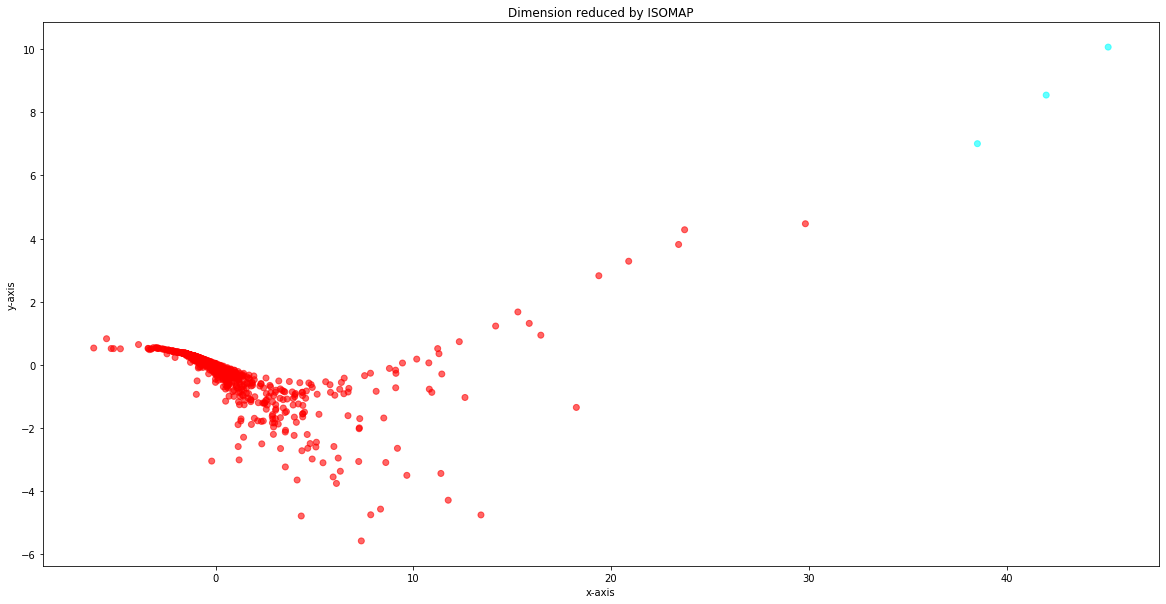

In [131]:
perform_spectral_cluster_quarter_wise(1,2, train)

### Spectral clustering on quarter 2

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.924681566375765
calsinki-H score on euclidean metric:  101.46957918787956
davis-B score on euclidean metric:  0.0504750851812273


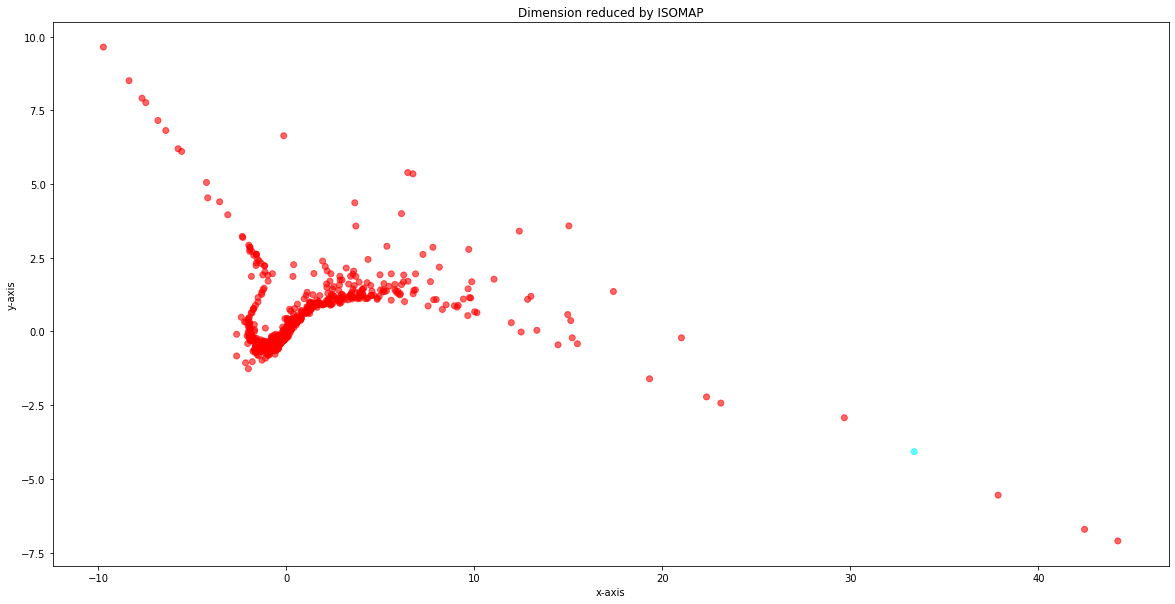

In [132]:
perform_spectral_cluster_quarter_wise(2,2, train)

### Spectral clustering on quarter 3

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.9261082648557276
calsinki-H score on euclidean metric:  107.82739846081655
davis-B score on euclidean metric:  0.05142134505666953


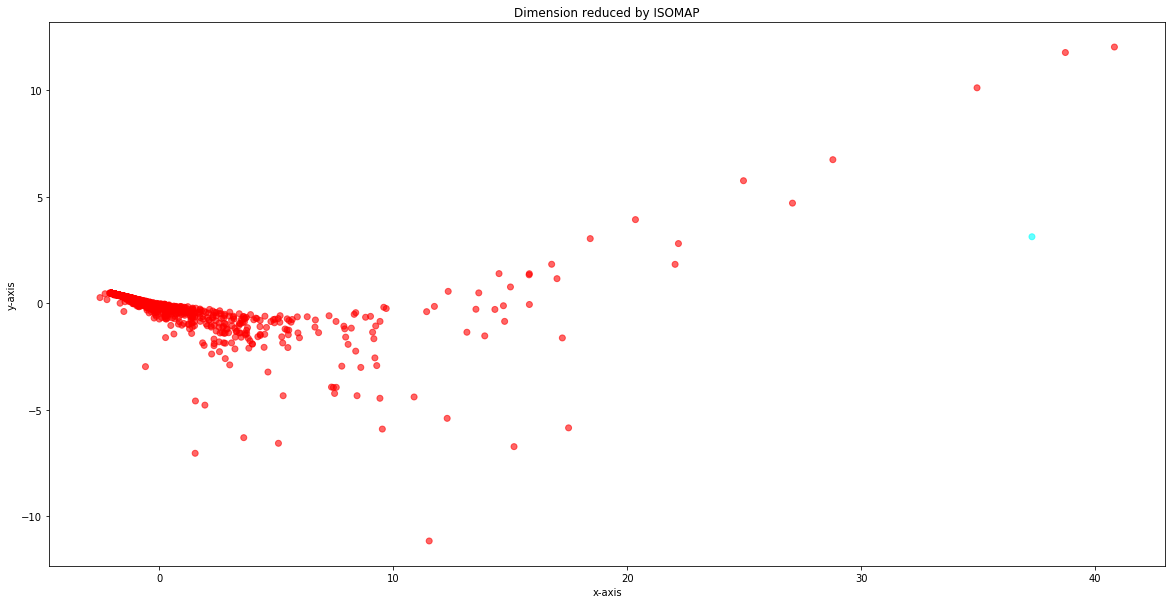

In [133]:
perform_spectral_cluster_quarter_wise(3,2, train)

### Spectral clustering on quarter 4

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.9462038808821907
calsinki-H score on euclidean metric:  223.50497261124042
davis-B score on euclidean metric:  0.03731340445537896


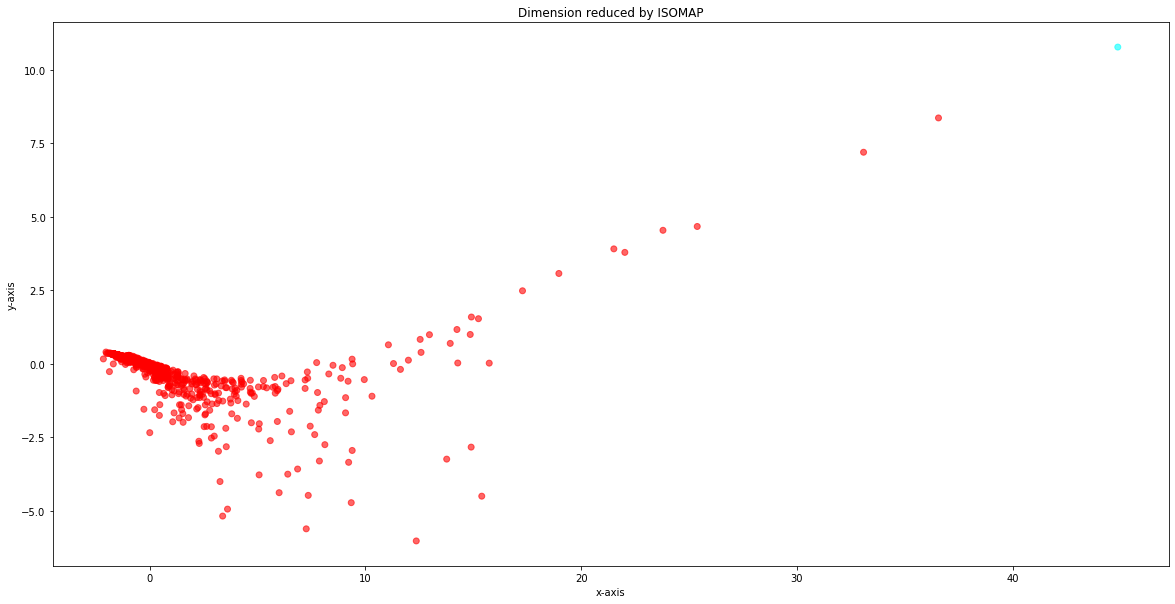

In [134]:
perform_spectral_cluster_quarter_wise(4,2, train)

### Spectral clustering on whole year - function testing part - can be ignored

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>


C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)


silhouette score on euclidean metric:  0.9183303693300521
calsinki-H score on euclidean metric:  93.58979875569452
davis-B score on euclidean metric:  0.054633414417215025


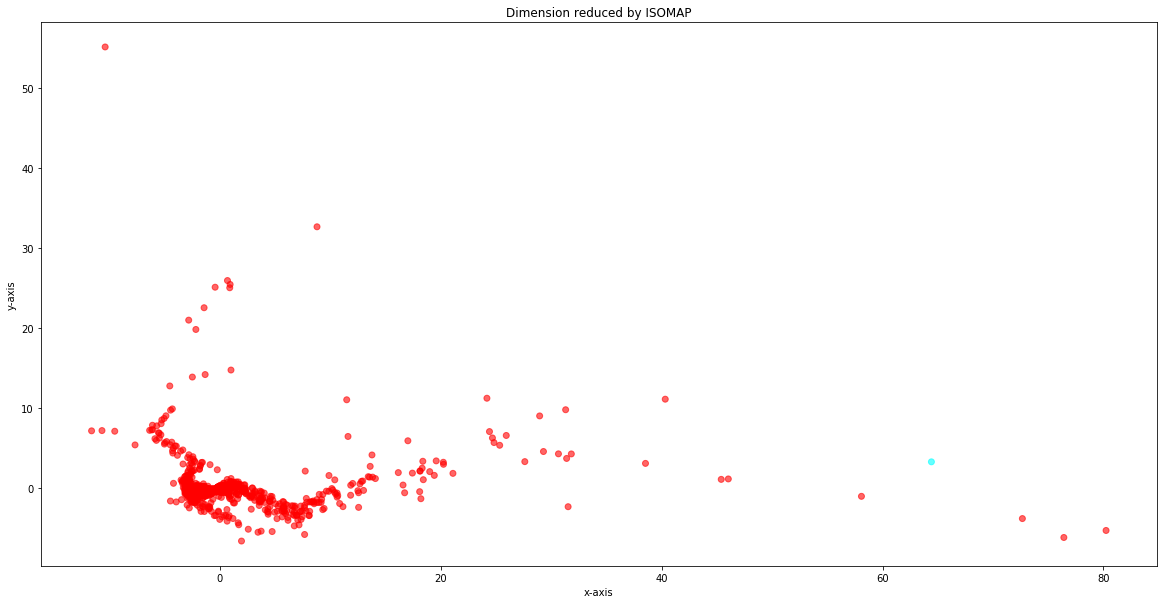

In [135]:
perform_spectral_cluster_quarter_wise(0, train=train)

### Perform Agglomerative clustering and see if any pattern can be extracted.

In [136]:
def plot_scipy_edndogram(pivot=None):
    z = sch.linkage(MinMaxScaler().fit_transform(pivot.values),"ward")
    plt.figure(figsize=(20,10))
    a = sch.dendrogram(z, show_leaf_counts=False,leaf_font_size=12.,show_contracted=True, leaf_rotation=90)
    return

def performAgglomerativeClustering(ncl = 2, affinity="euclidean", linkage="ward", X=None, pivot=None):
    AGModel = AgglomerativeClustering(n_clusters=ncl,affinity=affinity, linkage=linkage)
    x = MinMaxScaler().fit_transform(X)
    cluster_found = AGModel.fit_predict(x)
    #pivot.set_index("building_id", inplace=True)
    cluster_found = pd.Series(cluster_found, name="cluster")
    pivot.set_index(cluster_found, append=True, inplace=True)
    print("silhouette sample on euclidean metric: ",silhouette_samples(x, cluster_found))
    print("silhouette score on euclidean metric: ",silhouette_score(x, cluster_found))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(x, cluster_found))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(x, cluster_found))
    plot_isomap(x, pivot)
    plot_kernel_pca(x, pivot=pivot, kernel="rbf", g=15,rzev=True, deg = 1)
    plot_tsne(x, pivot)
    plot_umap(x, pivot)
    return pivot

def generate_dtw_matrix(pivot=None):
    from dtaidistance import dtw
    mat = dtw.distance_matrix(pivot)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if i == j:
                mat[i,j] = 0
            else:
                mat[j,i] = mat[i,j]
    return mat

def generate_quarter_pivot_matrix(quarter_no = 0,pivot=None):
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    return perHourElectricityConsumptionEachBuildingQ1

In [137]:
aggTrain = copy.deepcopy(train)

### Pivot over whole year data

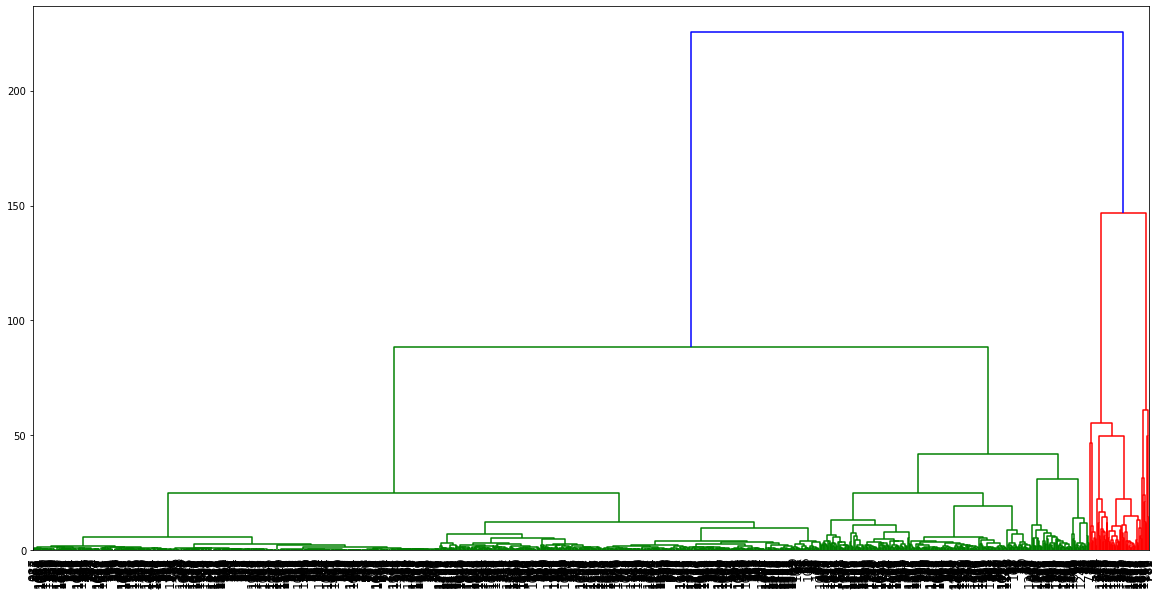

In [138]:
pivot = generate_quarter_pivot_matrix(0,aggTrain)
plot_scipy_edndogram(pivot = pivot)

silhouette sample on euclidean metric:  [0.84739325 0.90050119 0.91414984 ... 0.9103925  0.86638801 0.91052397]
silhouette score on euclidean metric:  0.8282540716071529
calsinki-H score on euclidean metric:  1248.5489632805536
davis-B score on euclidean metric:  0.7516679455108106


timestamp            2016-01-01 00:00:00  2016-01-01 01:00:00  \
building_id cluster                                             
0           1                      0.000                0.000   
1           1                      0.000                0.000   
2           1                      0.000                0.000   
3           1                      0.000                0.000   
4           0                      0.000                0.000   
...                                  ...                  ...   
1444        1                      5.425                5.550   
1445        1                      4.800                4.825   
1446        1                      0.000                0.000   
1447        1                    160.200              156.650   
1448        1                      2.325                2.225   

timestamp            2016-01-01 02:00:00  2016-01-01 03:00:00  \
building_id cluster                                             
0           1                      0.000                0.000   
1           1                      0.000                0.000   
2           1                      0.000                0.000   
3           1                      0.000                0.000   
4           0                      0.000                0.000   
...                                  ...                  ...   
1444        1                      5.900                5.525   
1445        1                      5.125                5.225   
1446        1                      0.000                0.000   
1447        1                    157.575              154.925   
1448        1                      2.275                2.575   

timestamp            2016-01-01 04:00:00  2016-01-01 05:00:00  \
building_id cluster                                             
0           1                      0.000                0.000   
1           1                      0.000                0.000   
2           1                      0.000                0.000   
3           1                      0.000                0.000   
4           0                      0.000                0.000   
...                                  ...                  ...   
1444        1                      5.725                5.600   
1445        1                      5.250                5.125   
1446        1                      0.000                0.000   
1447        1                    156.075              154.500   
1448        1                      3.075                2.725   

timestamp            2016-01-01 06:00:00  2016-01-01 07:00:00  \
building_id cluster                                             
0           1                      0.000                0.000   
1           1                      0.000                0.000   
2           1                      0.000                0.000   
3           1                      0.000                0.000   
4           0                      0.000                0.000   
...                                  ...                  ...   
1444        1                      5.725                5.675   
1445        1                      5.375                6.550   
1446        1                      0.000                0.000   
1447        1                    153.325              155.250   
1448        1                      4.550                3.575   

timestamp            2016-01-01 08:00:00  2016-01-01 09:00:00  ...  \
building_id cluster                                            ...   
0           1                      0.000                0.000  ...   
1           1                      0.000                0.000  ...   
2           1                      0.000                0.000  ...   
3           1                      0.000                0.000  ...   
4           0                      0.000                0.000  ...   
...                                  ...                  ...  ...   
1444        1                      4.425                

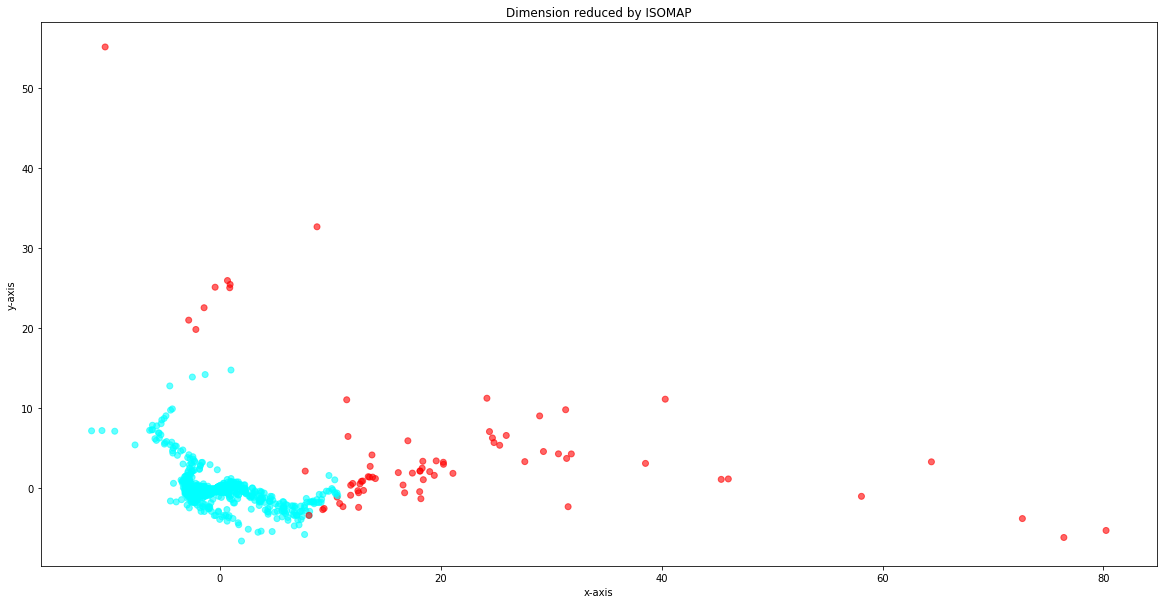

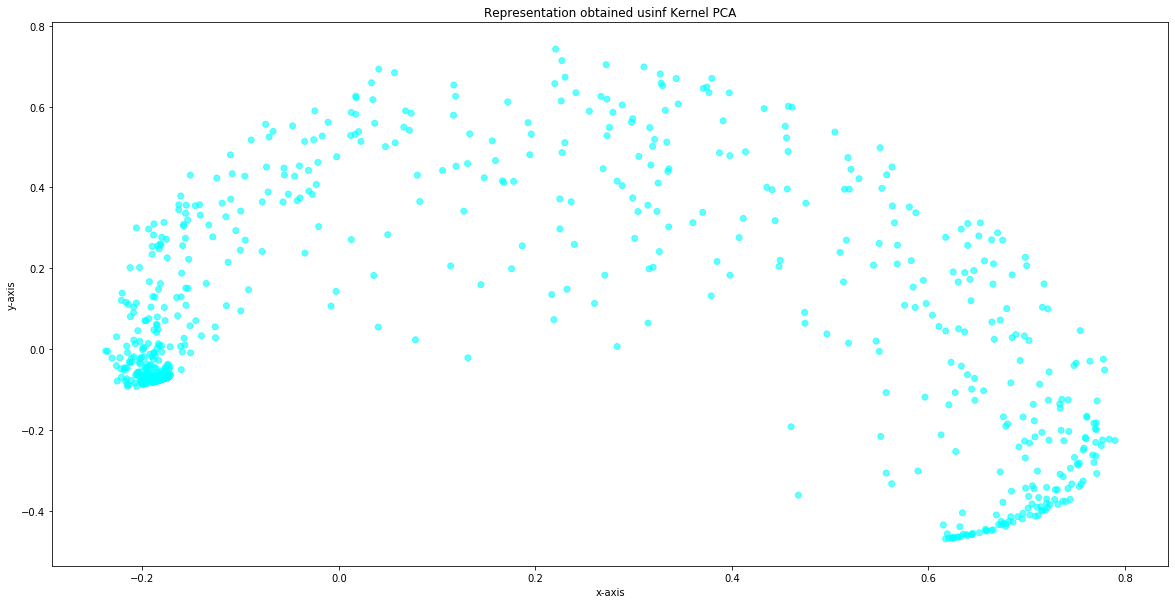

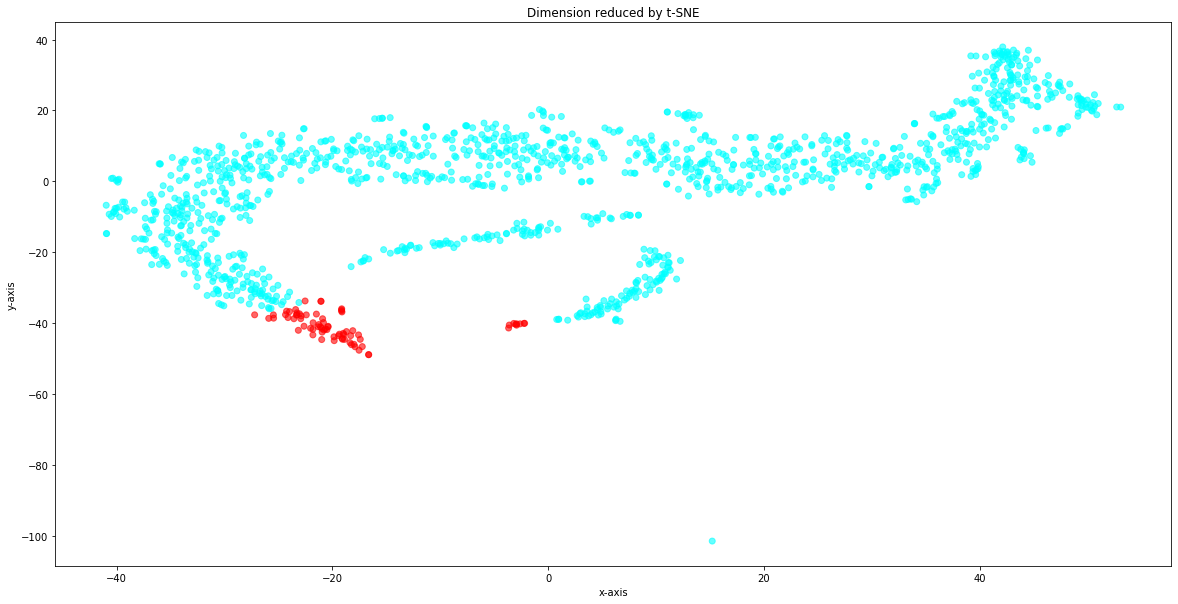

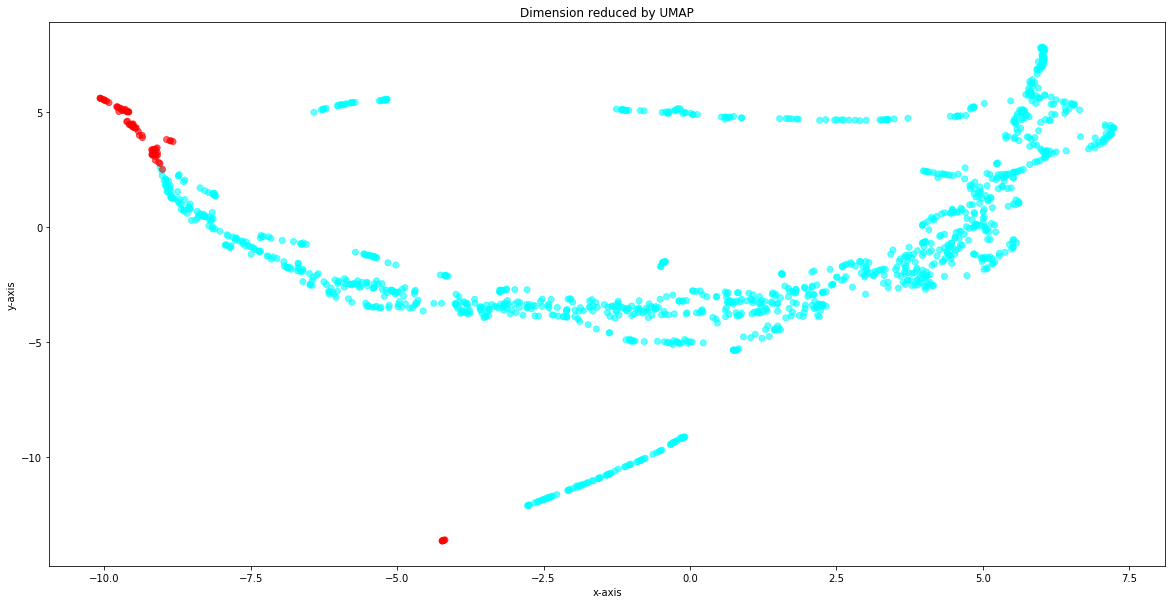

In [139]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

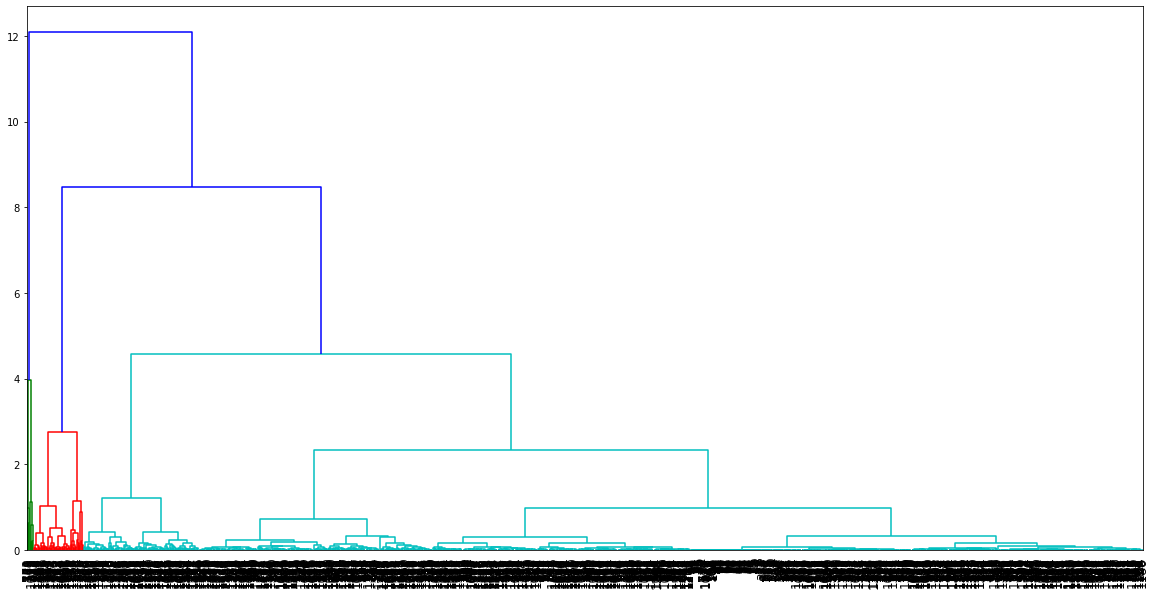

In [140]:
pivot = generate_quarter_pivot_matrix(1,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.96023736 0.96039188 0.96022531 ... 0.9609     0.94927495 0.96105146]
silhouette score on euclidean metric:  0.9377336489014594
calsinki-H score on euclidean metric:  1516.7706415770617
davis-B score on euclidean metric:  0.37514032268352004


hour                         0           1           2           3   \
building_id cluster                                                   
0           0          0.000000    0.000000    0.000000    0.000000   
1           0          0.135012    0.744066    0.270024    0.927081   
2           0          0.000000    0.018001    0.000000    0.000000   
3           0          0.000000    0.000000    0.000000    0.000000   
4           0          0.000000    0.907580    0.840074    0.997588   
...                         ...         ...         ...         ...   
1444        0          8.266860    8.277326    8.257558    8.271512   
1445        0          5.040116    5.085465    5.075581    5.113953   
1446        0          4.191860    0.394767    0.364535    0.174419   
1447        0        184.950000  180.844186  177.959884  175.097674   
1448        0          2.929651    2.805233    2.880233    2.680233   

hour                         4           5           6           7   \
building_id cluster                                                   
0           0          0.000000    0.412536    0.000000    0.000000   
1           0          0.768067    0.804071    0.192016    0.627055   
2           0          0.000000    0.000000    0.000000    0.000000   
3           0          0.000000    0.000000    0.000000    0.000000   
4           0          0.900079    0.802570    0.000000    0.000000   
...                         ...         ...         ...         ...   
1444        0          8.201744    8.237791    8.239024    7.235714   
1445        0          5.173837    5.243023    5.470122    6.835119   
1446        0          0.000000    0.641279    1.980952    3.578571   
1447        0        173.408140  173.402326  173.677381  172.908333   
1448        0          2.955233    4.116279    4.723214    4.759524   

hour                         8           9   ...          14          15  \
building_id cluster                          ...                           
0           0          0.480043    0.000000  ...    0.000000    0.000000   
1           0          0.129011    1.188105  ...    0.696060    0.255022   
2           0          0.000000    0.013501  ...    0.000000    0.000000   
3           0          0.000000    0.000000  ...    0.000000    0.000000   
4           0          0.937582    1.725153  ...    0.000000    2.970260   
...                         ...         ...  ...         ...         ...   
1444        0          4.755357    4.577381  ...    5.476786    5.479762   
1445        0          6.455357    6.012500  ...    5.561905    5.545833   
1446        0          4.911310    7.522817  ...    5.386905    4.471429   
1447        0        170.249405  168.280357  ...  173.583929  174.189286   
1448        0          4.607143    4.379762  ...    3.948810    4.032143   

hour                         16          17          18          19  \
building_id cluster                                                   
0           0          0.000000    0.577551    0.000000    0.000000   
1           0          0.255022    0.474042    1.317115    0.708063   
2           0          0.000000    0.000000    0.000000    0.000000   
3           0          0.000000    0.000000    0.000000    0.000000   
4           0          1.230110    0.900079    1.020090    0.855076   
...                         ...         ...         ...         ...   
1444        0          7.088690   10.080952   10.285714    9.157143   
1445        0          5.744048    6.067262    6.047619    5.914286   
1446        0          4.460119    3.160119    2.217262    1.644048   
1447        0        176.279762  190.324405  195.647619  195.431548   
1448        0          3.868452    4.300000    4.156548    3.377976   

hour                         20          21          22          23  
building_id cluster                                                  
0           0          0.000000    0.000000    0.000000    0.000000  
1           0          0.5130

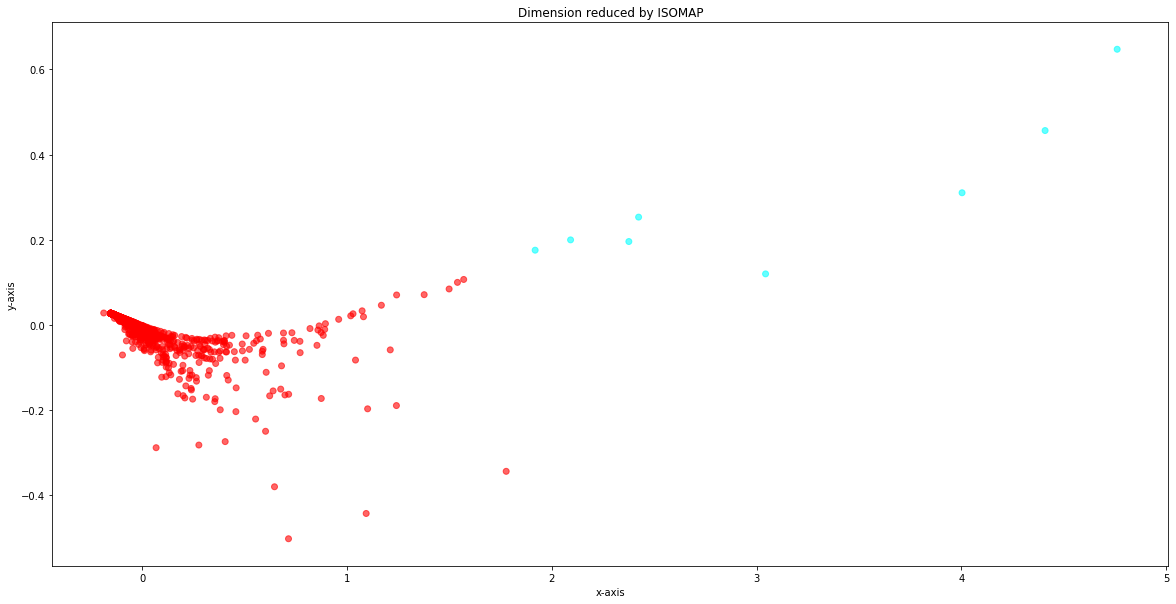

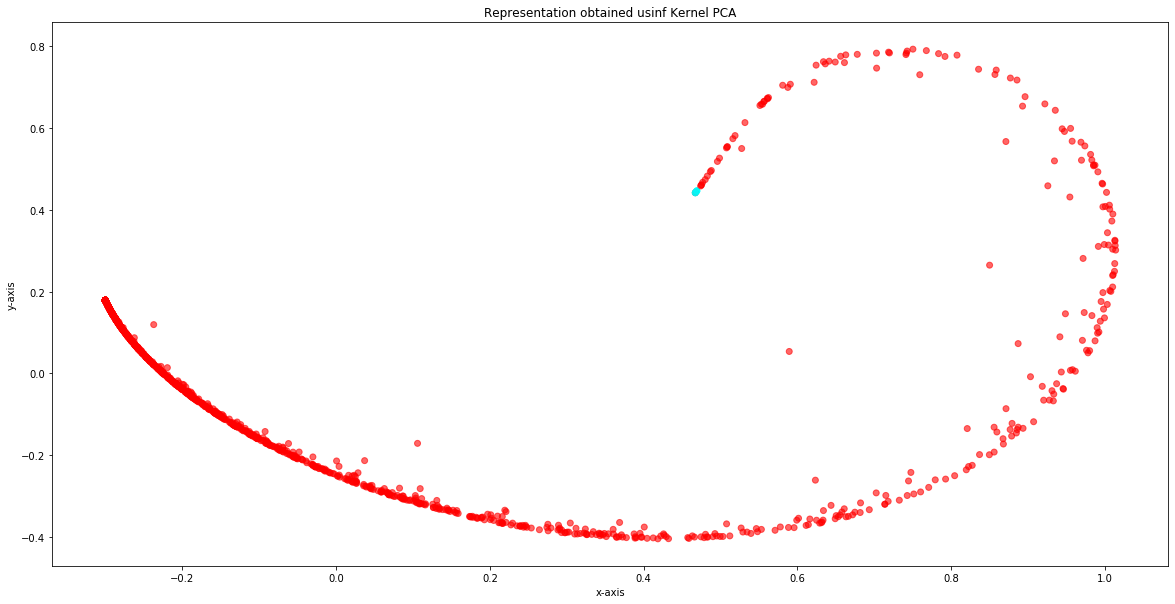

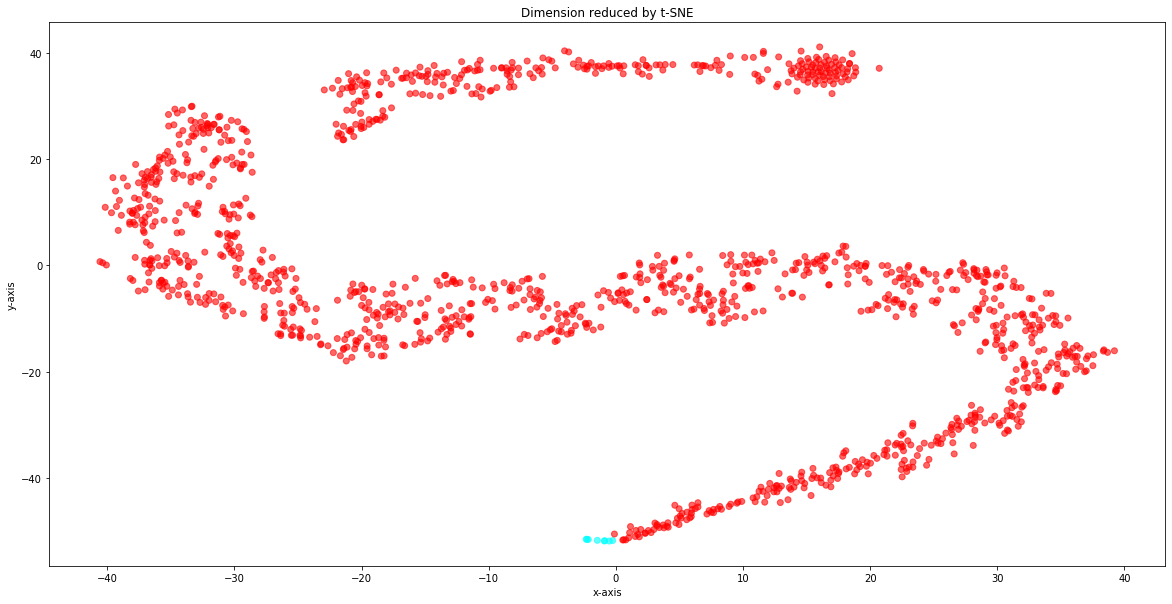

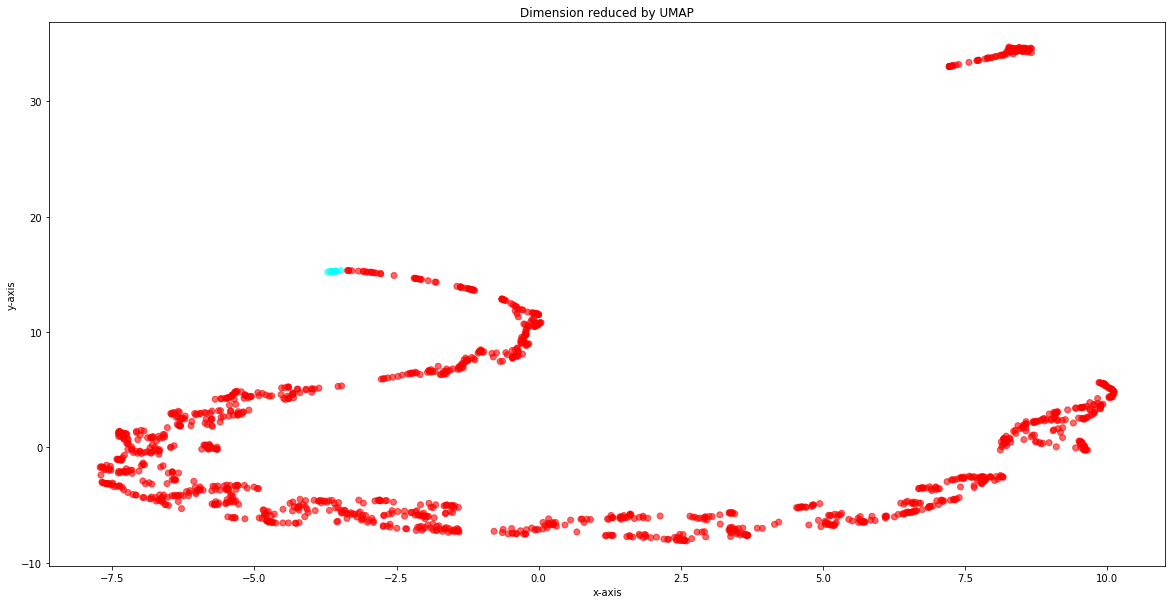

In [141]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

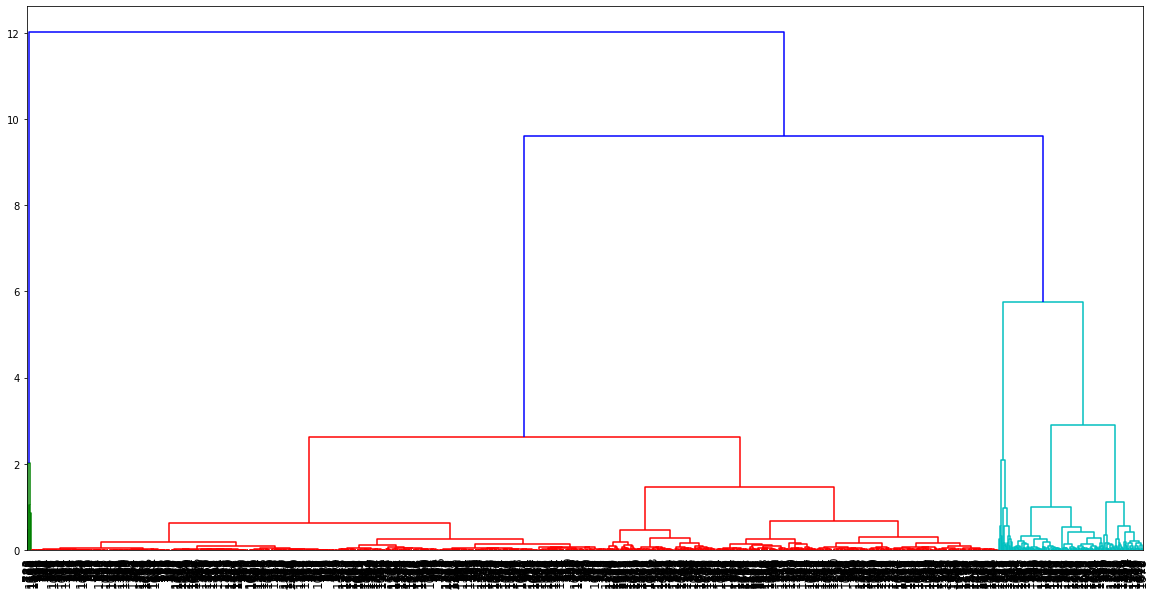

In [142]:
pivot = generate_quarter_pivot_matrix(2,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.86622605 0.90496045 0.89304527 ... 0.88647064 0.72937225 0.88633142]
silhouette score on euclidean metric:  0.7745933218960885
calsinki-H score on euclidean metric:  2367.3673826699546
davis-B score on euclidean metric:  0.5071395924941196


hour                         0           1           2           3   \
building_id cluster                                                   
0           2        107.919527  108.624626  109.209648  109.532209   
1           2         61.103366   60.665343   60.182304   59.564233   
2           2          3.334792    3.267292    3.163777    3.235785   
3           2        183.263692  184.598813  186.402692  187.891593   
4           0        725.209121  721.233407  720.250705  714.887692   
...                         ...         ...         ...         ...   
1444        2          7.854121    7.921429    7.664286    7.568132   
1445        2          3.979670    3.976648    4.036264    4.053846   
1446        2          3.445604    0.290659    0.137088    0.034890   
1447        2        195.514560  192.198901  187.140934  182.952198   
1448        2          2.432692    2.426923    2.408791    2.398901   

hour                         4           5           6           7   \
building_id cluster                                                   
0           2        109.832220  110.469714  109.404670  109.862231   
1           2         61.055387   59.681274   58.925167   58.730186   
2           2          3.447307    6.264548    6.129540    6.291556   
3           2        188.019055  190.348000  191.386901  195.369725   
4           0        715.555714  717.243187  717.550769  718.915934   
...                         ...         ...         ...         ...   
1444        2          7.487637    7.137363    5.262363    5.130495   
1445        2          4.059890    4.106593    4.125000    5.378333   
1446        2          0.036813    0.780495    4.819780    6.932143   
1447        2        180.862088  177.125000  167.591209  171.637637   
1448        2          2.375824    3.540293    3.899176    3.788187   

hour                         8           9   ...          14          15  \
building_id cluster                          ...                           
0           2        111.377341  107.236966  ...  112.569953  111.804868   
1           2         61.064381   58.415169  ...   62.243511   61.475402   
2           2          7.367151   10.548927  ...   16.718973   16.601963   
3           2        214.203912  212.718758  ...  196.629912  192.189451   
4           0        737.915058  775.050879  ...  801.040549  800.253077   
...                         ...         ...  ...         ...         ...   
1444        2          5.386997    5.585989  ...    5.512363    4.871429   
1445        2          4.876740    4.742582  ...    4.991484    4.934537   
1446        2          8.232143    8.492308  ...    4.822527    4.344871   
1447        2        180.703484  181.871703  ...  184.734615  185.545143   
1448        2          3.664652    3.842308  ...    3.535714    3.679212   

hour                         16          17          18          19  \
building_id cluster                                                   
0           2        110.799769  108.632110  109.749670  114.635275   
1           2         61.001374   59.564269   59.813253   61.556348   
2           2         16.349944   15.089832   13.658705   13.027168   
3           2        188.289088  183.616209  183.668703  192.945352   
4           0        795.490110  777.886264  773.205824  806.017363   
...                         ...         ...         ...         ...   
1444        2          5.459615    5.833791    6.062912    6.150275   
1445        2          5.064286    5.140476    5.052473    4.904121   
1446        2          3.553571    2.957967    2.921429    1.849176   
1447        2        187.219780  188.044593  189.351099  190.059341   
1448        2          3.461264    3.454762    3.101648    2.483516   

hour                         20          21          22          23  
building_id cluster                                                  
0           2        108.309549  109.352176  109.607176  111.114802  
1           2         58.6851

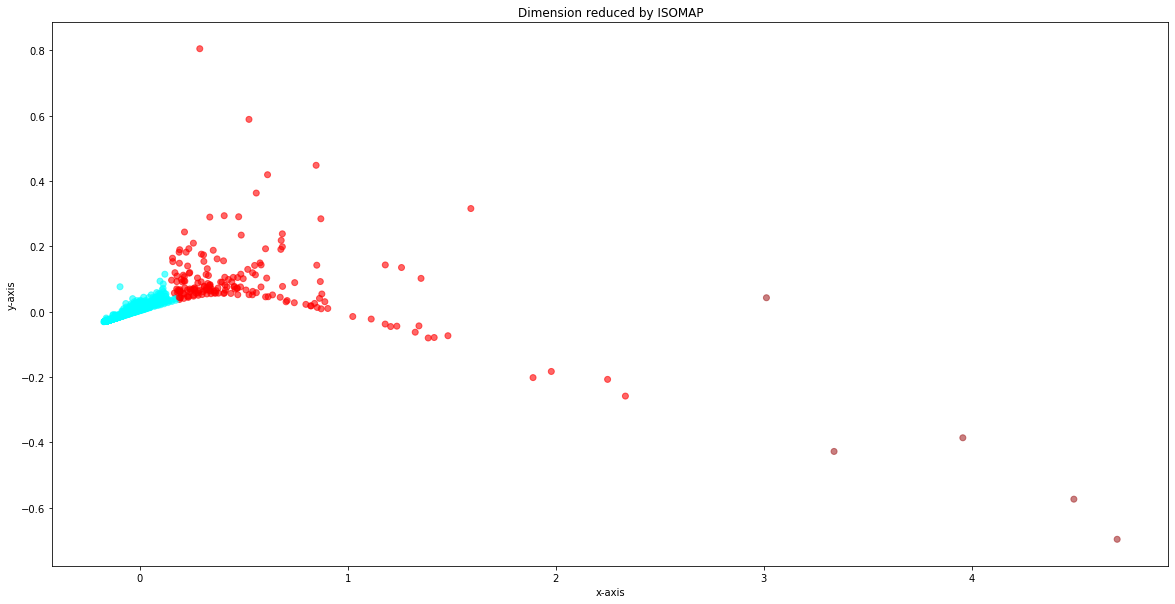

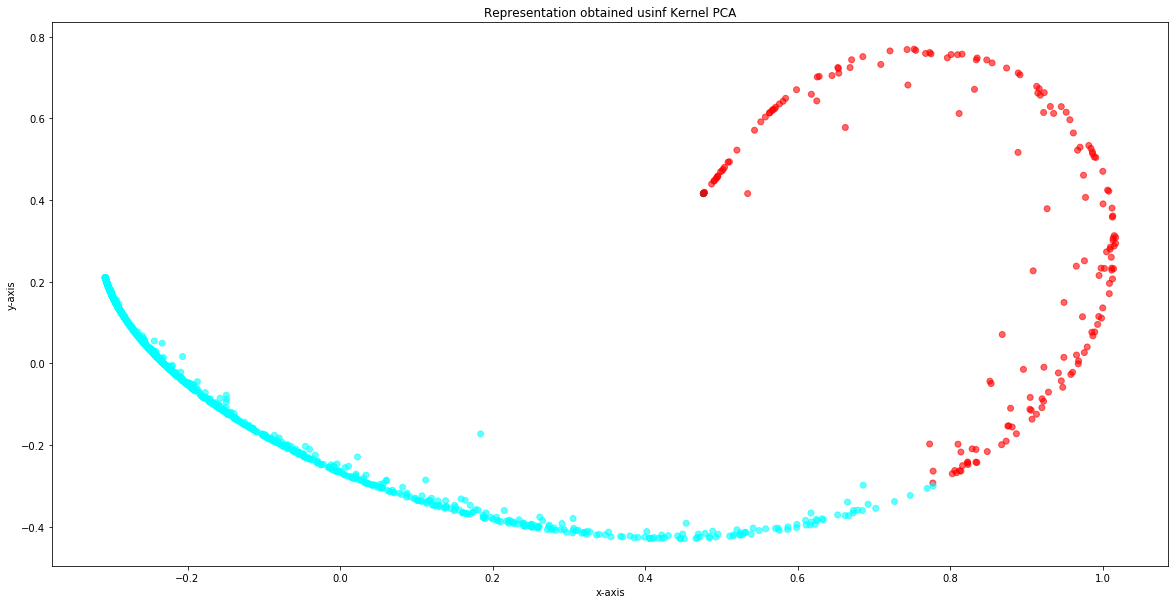

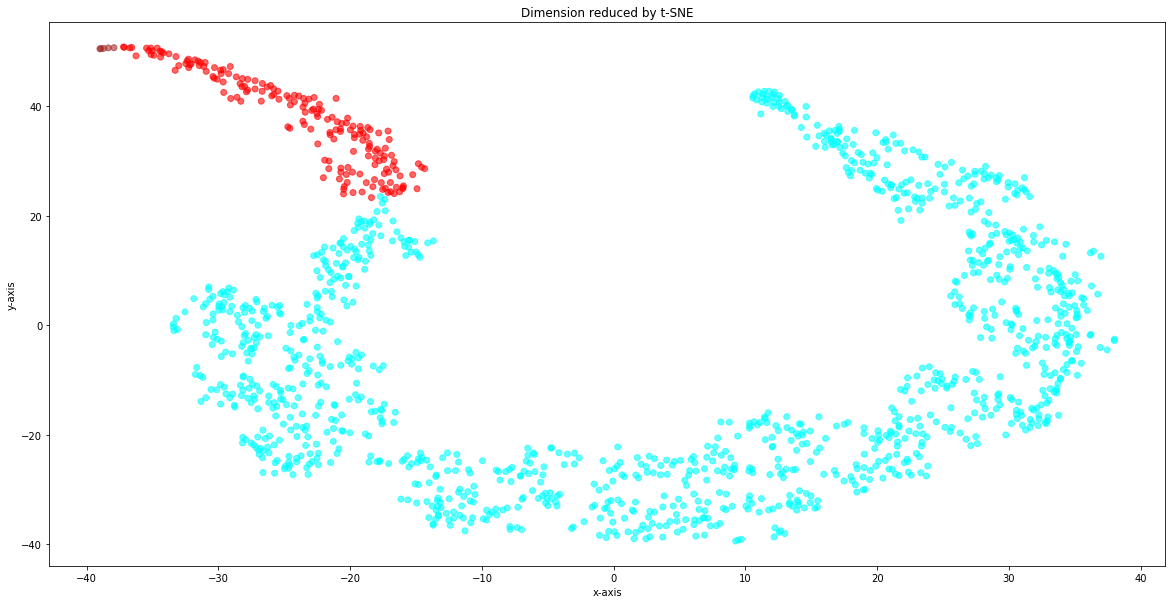

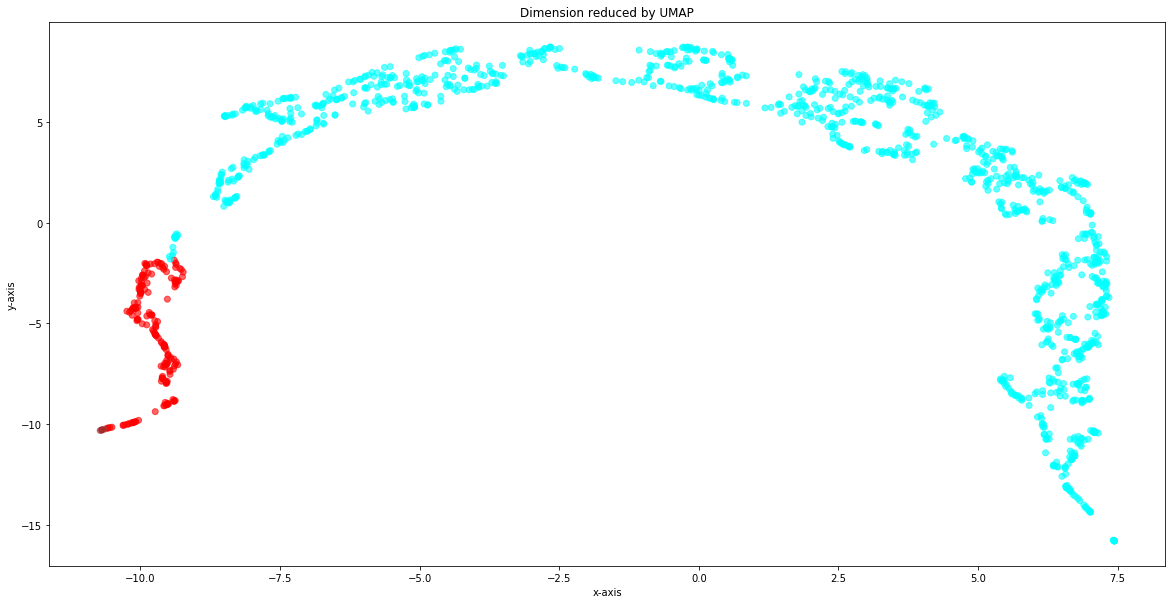

In [143]:
performAgglomerativeClustering(ncl=3, X=pivot.values, pivot=pivot)

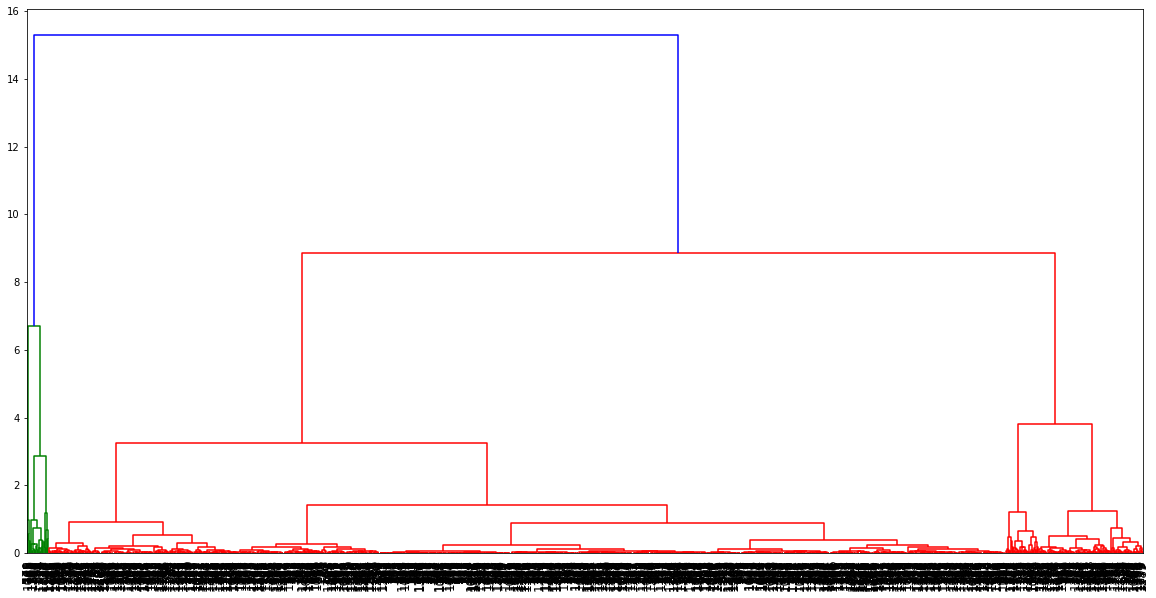

In [144]:
pivot = generate_quarter_pivot_matrix(3,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.89533041 0.93588754 0.94167969 ... 0.93503001 0.92360126 0.93497544]
silhouette score on euclidean metric:  0.8937767528087474
calsinki-H score on euclidean metric:  1875.2160934414437
davis-B score on euclidean metric:  0.46667013476150676


hour                          0            1            2            3   \
building_id cluster                                                       
0           0         267.719424   268.951011   269.551989   268.587478   
1           0         138.117500   138.084859   138.423163   138.441000   
2           0          17.018007    16.439313    16.181129    15.967457   
3           0         393.566413   396.148326   397.925185   397.791641   
4           1        1602.272609  1594.698370  1589.015326  1581.454783   
...                          ...          ...          ...          ...   
1444        0           6.728571     6.695562     6.682880     6.766576   
1445        0           3.032692     2.931975     2.927174     2.912500   
1446        0           3.078804     0.362500     0.065217     0.065217   
1447        0         189.403533   185.135870   181.047011   177.783696   
1448        0           2.852717     2.807609     2.958152     2.871467   

hour                          4            5            6            7   \
building_id cluster                                                       
0           0         266.621402   264.922391   262.748620   268.654261   
1           0         138.722859   137.874152   136.666337   138.135283   
2           0          17.445343    24.238308    23.303492    25.814128   
3           0         399.976522   402.547250   398.923011   400.978130   
4           1        1575.957174  1586.417717  1593.028696  1600.343913   
...                          ...          ...          ...          ...   
1444        0           6.678804     6.501630     5.436141     5.510326   
1445        0           2.879076     2.868478     2.831793     4.514674   
1446        0           0.000000     0.545380     4.824728     7.241033   
1447        0         177.009783   175.283967   167.967663   171.108424   
1448        0           2.943478     3.525272     3.758424     3.602717   

hour                          8            9   ...           14           15  \
building_id cluster                            ...                             
0           0         274.737935   266.050141  ...   274.990185   274.300207   
1           0         138.262913   132.582887  ...   133.446554   133.538565   
2           0          30.016326    36.515489  ...    47.176780    47.163425   
3           0         422.634609   431.051598  ...   402.562217   402.573279   
4           1        1628.640217  1688.178696  ...  1772.764891  1765.531087   
...                          ...          ...  ...          ...          ...   
1444        0           5.237862     4.916576  ...     4.736264     4.487363   
1445        0           3.717753     3.754891  ...     5.116033     5.398352   
1446        0           7.696467     8.056522  ...     4.472826     4.080978   
1447        0         181.742576   182.096196  ...   182.561685   184.243391   
1448        0           3.571921     3.600815  ...     3.553804     3.679348   

hour                          16           17           18           19  \
building_id cluster                                                       
0           0         273.795728   270.813217   268.810043   265.508543   
1           0         133.232848   133.268533   132.933141   133.084478   
2           0          45.819074    42.747560    38.554265    36.390849   
3           0         391.652310   382.868083   378.093815   374.080054   
4           1        1753.266196  1712.128043  1671.597283  1655.304783   
...                          ...          ...          ...          ...   
1444        0           3.918956     4.285440     4.640217     5.457692   
1445        0           5.367033     5.454396     5.225843     5.131793   
1446        0           3.713043     3.932609     4.054891     3.328261   
1447        0         185.198641   186.876359   186.676087   191.150543   
1448        0           3.451630     3.404076     3.126359     2.866576   

hour                          2

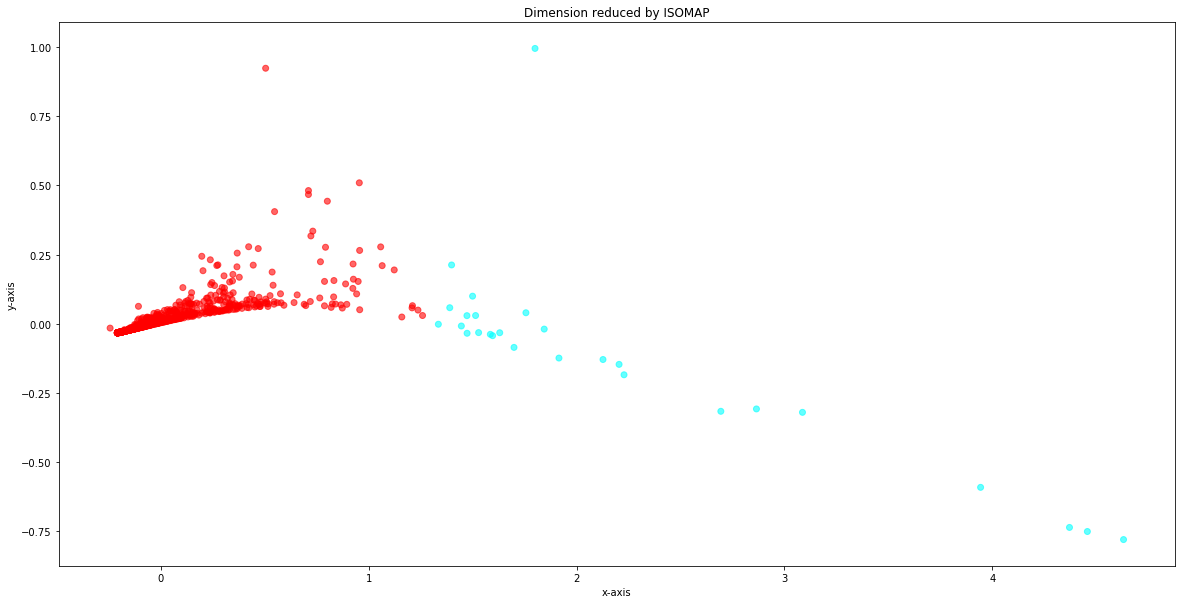

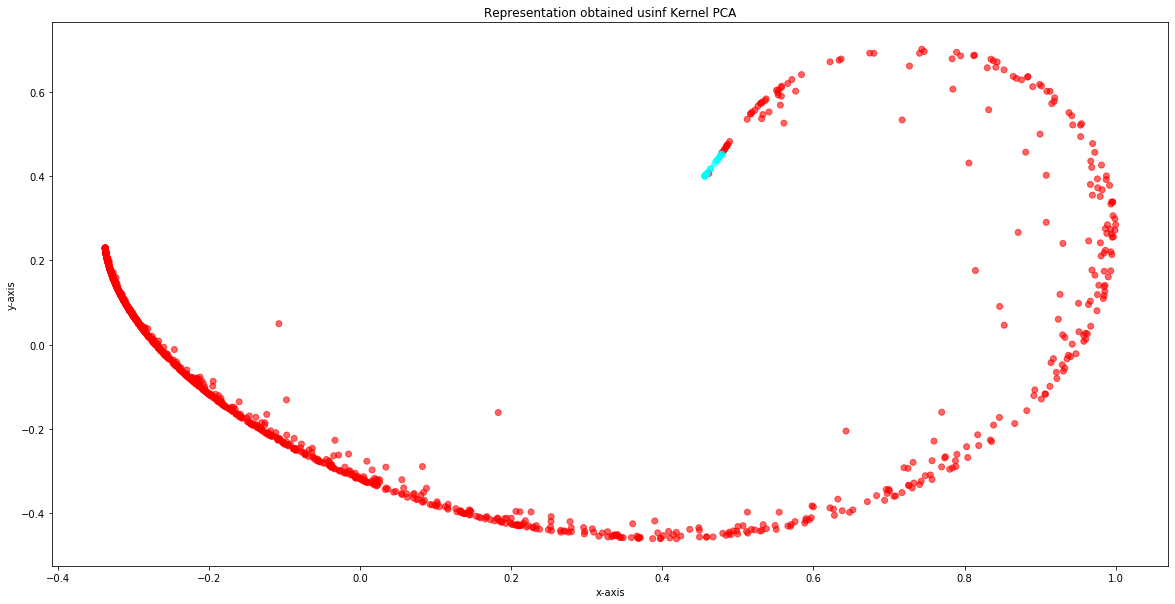

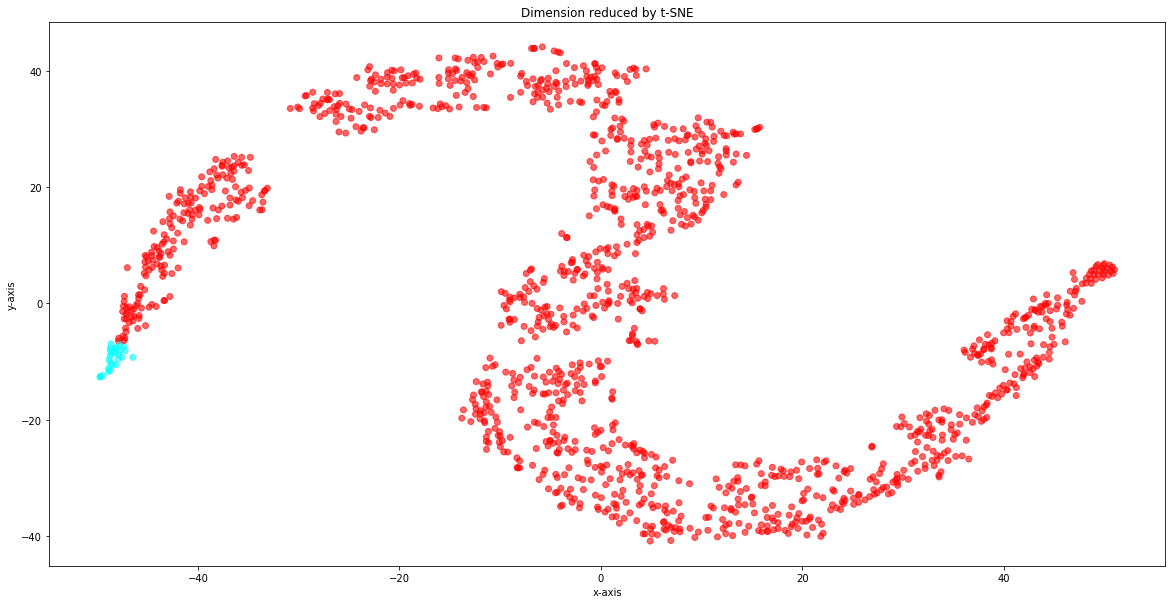

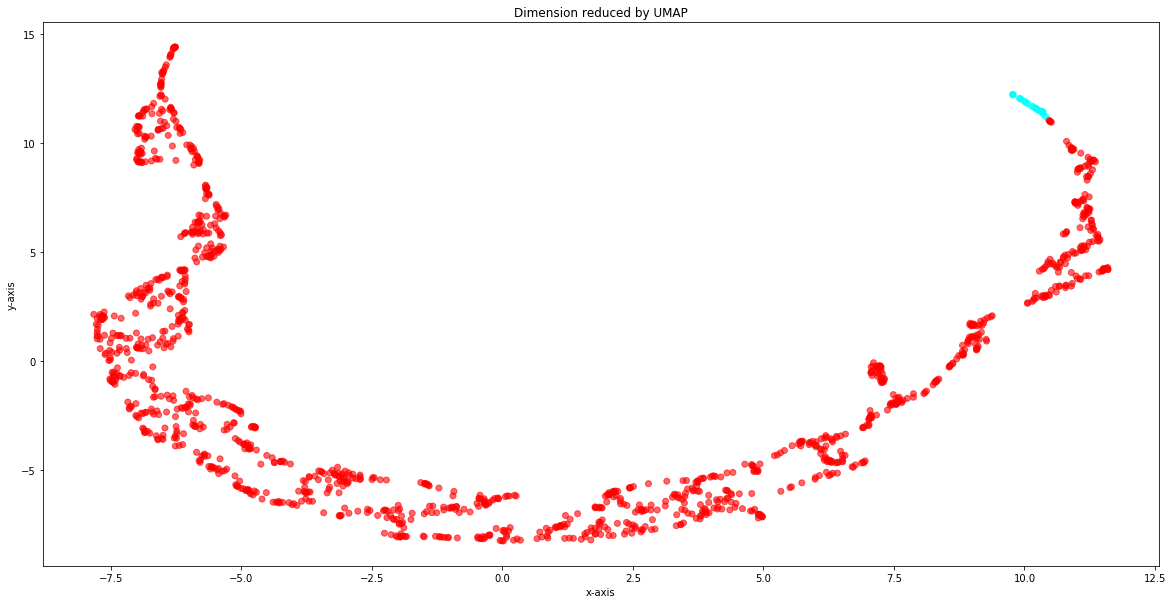

In [145]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

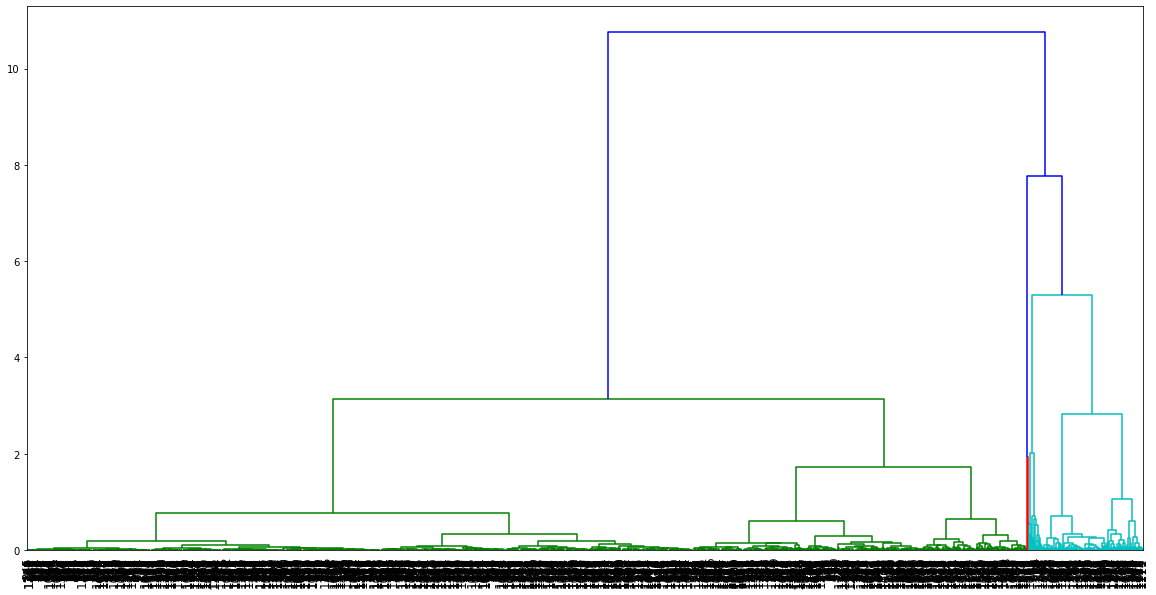

In [146]:
pivot = generate_quarter_pivot_matrix(4,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.75802932 0.88928652 0.90105267 ... 0.89112701 0.77391848 0.89207041]
silhouette score on euclidean metric:  0.7892624245863386
calsinki-H score on euclidean metric:  1894.566887586631
davis-B score on euclidean metric:  0.5135386632308806


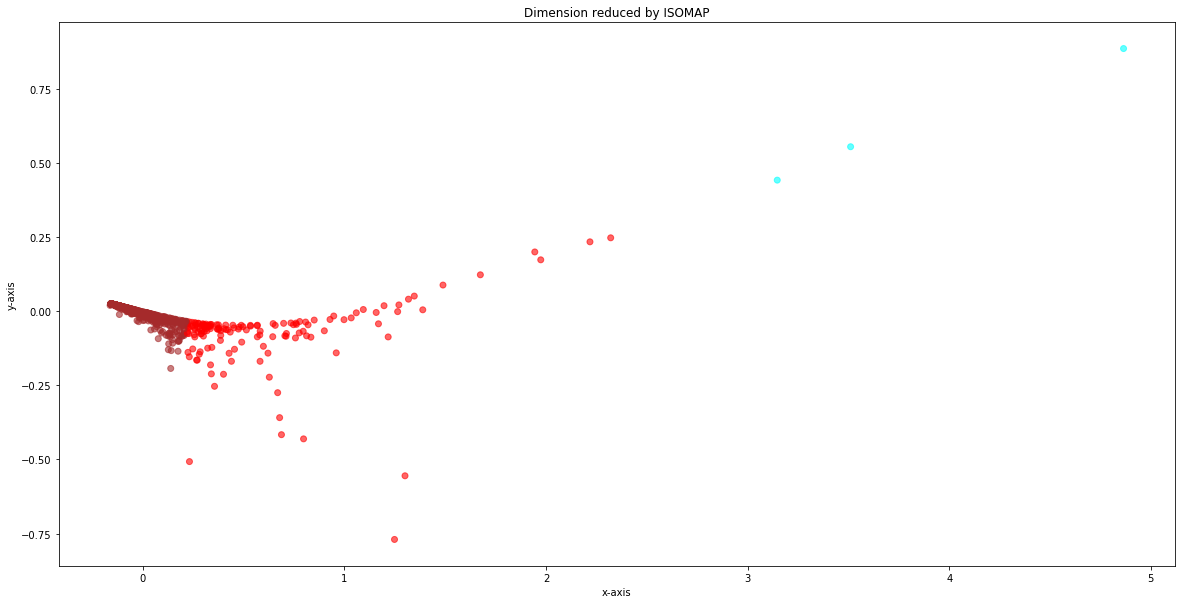

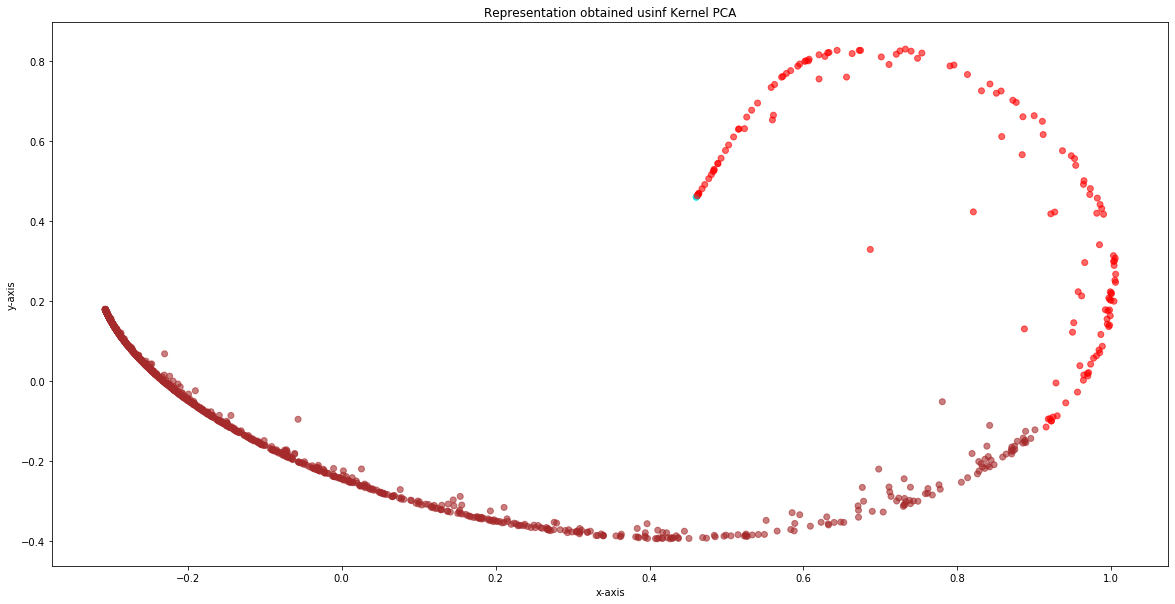

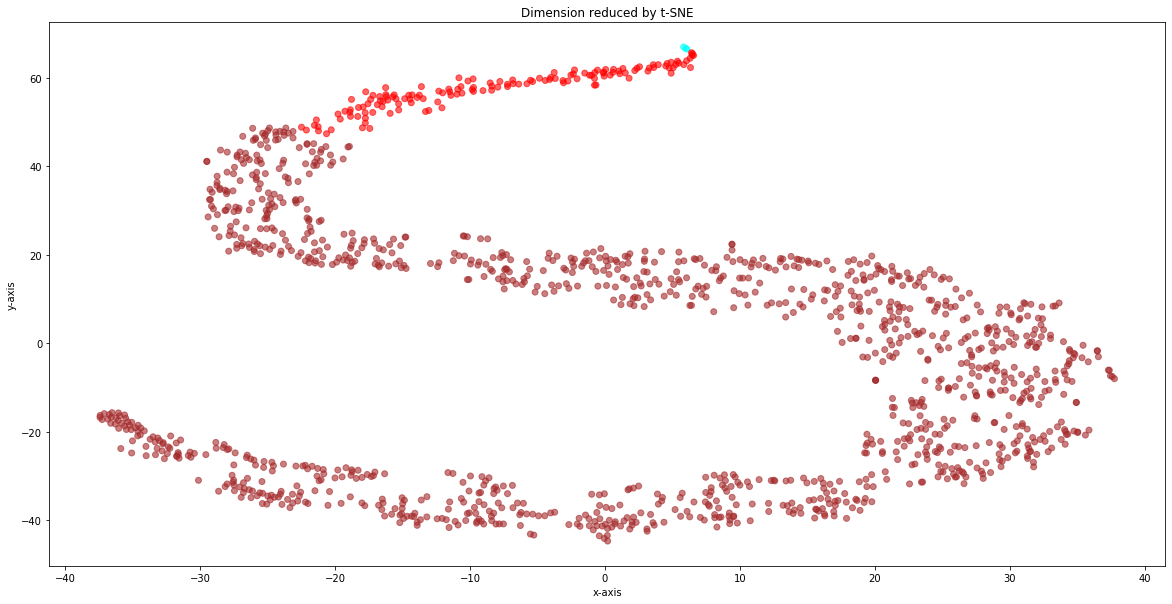

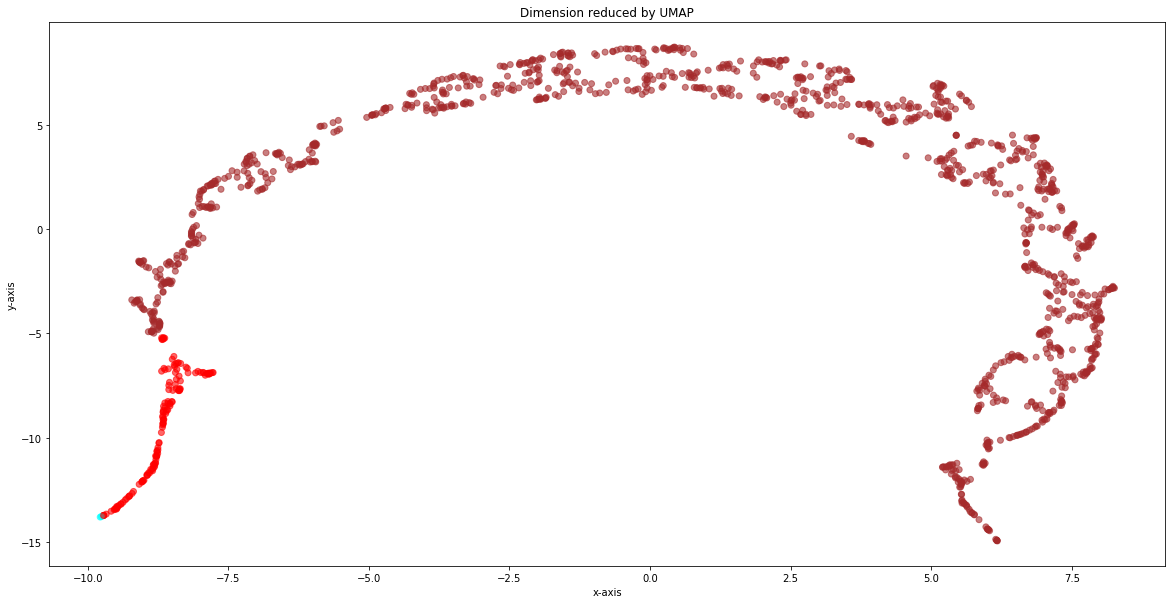

In [147]:
p = performAgglomerativeClustering(ncl=3, X=pivot.values, pivot=pivot)

In [148]:
p[p.index.get_level_values("cluster") ==1 ]

hour                         0           1           2           3   \
building_id cluster                                                   
0           1        209.271522  208.633454  208.529575  210.525308   
1           1         96.941341   96.448705   95.359577   93.958845   
2           1         11.150960   10.180535    9.806610    9.321399   
3           1        324.609268  324.238377  324.256913  324.468322   
5           1         15.079380   14.367142   13.758780   13.695715   
...                         ...         ...         ...         ...   
1444        1         10.256686   10.131395   10.067442    9.950291   
1445        1          4.451163    4.462500    4.410465    4.450872   
1446        1          3.401453    0.696802    0.018314    0.043023   
1447        1        199.699419  194.430523  188.108430  183.015407   
1448        1          3.144706    3.168235    3.152353    3.102647   

hour                         4           5           6           7   \
building_id cluster                                                   
0           1        209.894713  210.176637  209.835396  211.845946   
1           1         93.531525   92.896441   92.187157   92.139688   
2           1          9.232370   10.857159   11.587199   11.805328   
3           1        324.620440  325.399423  331.627784  341.688166   
5           1         12.753486   13.109601   12.137698   11.729649   
...                         ...         ...         ...         ...   
1444        1         10.306395   10.361919   10.986919   10.162015   
1445        1          4.456105    4.482558    4.483721    5.511628   
1446        1          0.000000    0.462500    3.221221    4.523547   
1447        1        180.229651  178.942058  179.374709  178.761047   
1448        1          3.154706    3.861079    4.100980    3.948529   

hour                         8           9   ...          14          15  \
building_id cluster                          ...                           
0           1        210.829498  203.885125  ...  194.611343  194.789370   
1           1         92.700605  103.493900  ...  108.455871  110.456098   
2           1         14.725493   18.086366  ...   25.569299   26.633197   
3           1        348.161361  361.211630  ...  360.354712  354.189377   
5           1         11.970770   13.313628  ...   26.924028   28.337374   
...                         ...         ...  ...         ...         ...   
1444        1          8.303779    7.886628  ...    8.474405    8.466265   
1445        1          5.163663    5.029845  ...    4.825872    4.974412   
1446        1          6.137209    6.794767  ...    6.754360    6.245882   
1447        1        183.414535  181.749616  ...  186.652616  188.126471   
1448        1          3.879412    3.712353  ...    3.360882    3.449702   

hour                         16          17          18          19  \
building_id cluster                                                   
0           1        196.295435  197.905424  204.018739  207.854421   
1           1        110.960566  112.414677  112.741155  107.767355   
2           1         25.564845   22.039273   19.007821   16.697499   
3           1        340.775604  339.588504  350.791457  355.495196   
5           1         28.645267   26.779359   24.894892   21.971758   
...                         ...         ...         ...         ...   
1444        1          9.979651   13.266570   14.080814   13.978198   
1445        1          5.065407    5.325291    5.310465    5.340116   
1446        1          5.713372    5.201744    4.566570    2.412791   
1447        1        192.279651  202.475291  207.124419  211.642151   
1448        1          3.422059    3.684412    3.585000    3.191765   

hour                         20          21          22          23  
building_id cluster                                                  
0           1        208.707654  207.320315  207.936120  209.197305  
1           1        104.3308

# Dtw distance with agglomerative clustering

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(0, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

pivot generated


In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix1 = generate_quarter_pivot_matrix(1, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix1 = generate_dtw_matrix(dtwMatrix1.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix1)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix1, pivot=generate_quarter_pivot_matrix(1, aggTrain))

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix1 = generate_quarter_pivot_matrix(2, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix1 = generate_dtw_matrix(dtwMatrix1.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix1)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix1, pivot=generate_quarter_pivot_matrix(1, aggTrain))

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix1 = generate_quarter_pivot_matrix(3, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix1 = generate_dtw_matrix(dtwMatrix1.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix1)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix1, pivot=generate_quarter_pivot_matrix(1, aggTrain))

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix1 = generate_quarter_pivot_matrix(4, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix1 = generate_dtw_matrix(dtwMatrix1.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix1)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix1, pivot=generate_quarter_pivot_matrix(1, aggTrain))

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]